## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import math
import pickle

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error



## Define the functions to be used 

In [2]:
from statistics import stdev

def Average(data):
    return sum(data) / len(data)

def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

In [3]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [4]:
def plot_graphs(history, metric, model):
    plt.plot(history[metric])
    plt.plot(history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of {model}")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

# Dataset

## Read Dataset

In [5]:
dataset = pd.read_excel('./dataset21Apr-21Jun2022.xlsx')
dataset = dataset[['date', 'pm2p5']]

In [6]:
dataset.describe()

pm2p5
count  1488.000000
mean     30.823925
std      76.192929
min      -3.000000
25%      14.000000
50%      22.000000
75%      33.000000
max     985.000000

Text(0.5, 1.0, 'Raw Data of Hourly Data PM2.5 from Apr 21st - Jun 21st 2022')

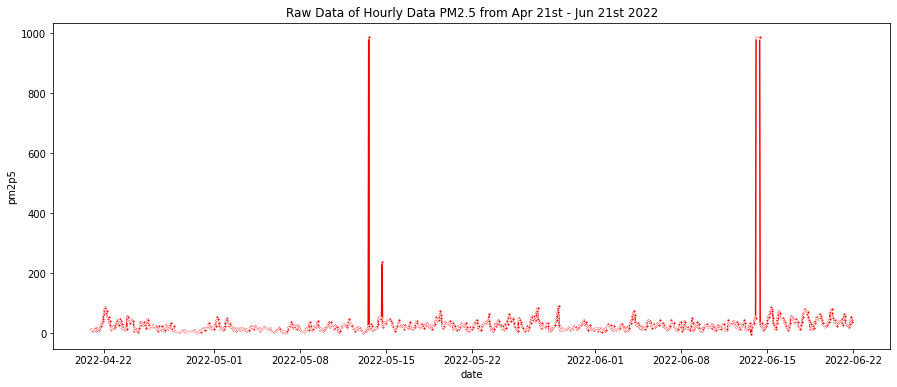

In [7]:
plt.subplots(figsize = (15,6)) 
sns.lineplot(x="date", y="pm2p5",
             data=dataset, marker='.', color='red')
plt.title("Raw Data of Hourly Data PM2.5 from Apr 21st - Jun 21st 2022")

## Remove negative values and above 200

In [8]:
for i in range(len(dataset)):
    if dataset['pm2p5'][i] < 0 or dataset['pm2p5'][i] > 200:
        dataset['pm2p5'][i] = np.nan

c:\Python\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
dataset.describe()

pm2p5
count  1476.000000
mean     24.911247
std      15.220311
min       1.000000
25%      14.000000
50%      21.000000
75%      33.000000
max      91.000000

In [10]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1488 non-null   datetime64[ns]
 1   pm2p5   1476 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.4 KB
None


<AxesSubplot:>

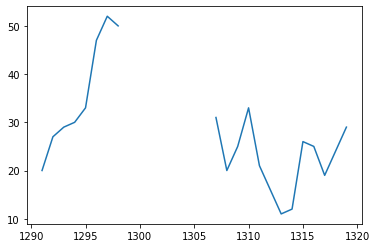

In [11]:
dataset['pm2p5'][1290:1320].plot()

## Fill empty data with interpolate method

In [12]:
dataset['pm2p5'] = dataset['pm2p5'].interpolate(option='spline')

In [13]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1488 non-null   datetime64[ns]
 1   pm2p5   1488 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.4 KB
None


<AxesSubplot:>

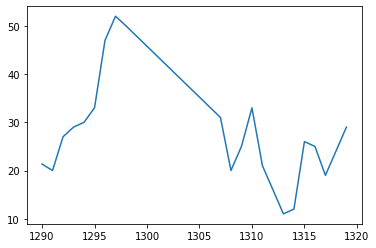

In [14]:
dataset['pm2p5'][1290:1320].plot()

Text(0.5, 1.0, 'Hourly Data PM2.5 from Apr 21st - Jun 21st 2022')

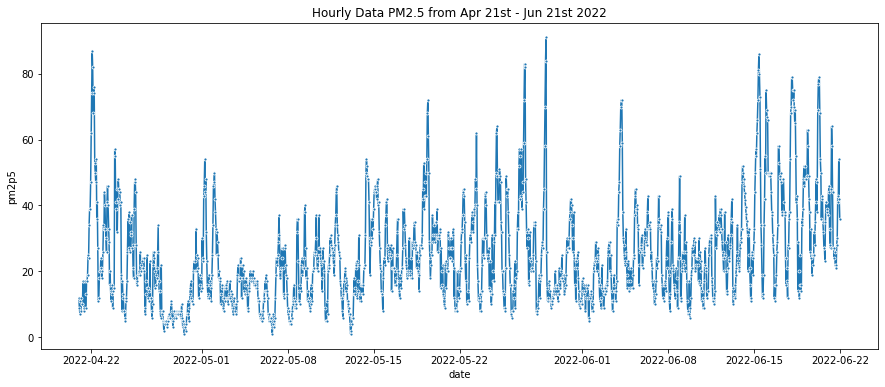

In [15]:
from turtle import color


plt.subplots(figsize = (15,6))
sns.lineplot(x="date", y="pm2p5",
             data=dataset, marker='.')
plt.title("Hourly Data PM2.5 from Apr 21st - Jun 21st 2022")

In [16]:
dataset.describe()

pm2p5
count  1488.000000
mean     24.992608
std      15.206912
min       1.000000
25%      14.000000
50%      22.000000
75%      33.000000
max      91.000000

## Split data to validation and testing

split data with proportion 70% for training data, 20% for validation data and 10% for testing

In [17]:
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

In [18]:
SPLIT_TIME_TRAIN_REM = int(math.floor(0.7*((len(dataset))/24)) * 24) 
SPLIT_TIME_TRAIN_REM

1032

In [19]:
data_train = dataset[:SPLIT_TIME_TRAIN_REM]['pm2p5']
data_train = pd.DataFrame(data_train)
data_train.index = dataset[:SPLIT_TIME_TRAIN_REM]['date']

data_rem = dataset[SPLIT_TIME_TRAIN_REM:]['pm2p5']
data_rem = pd.DataFrame(data_rem)
data_rem.index = dataset[SPLIT_TIME_TRAIN_REM:]['date']

In [20]:
SPLIT_TIME_VAL_TEST = int(math.floor(0.87*((len(data_rem))/24)) * 24) 
SPLIT_TIME_VAL_TEST

384

In [21]:
data_val = data_rem[:SPLIT_TIME_VAL_TEST]
data_val = pd.DataFrame(data_val)

data_test = data_rem[SPLIT_TIME_VAL_TEST:]
data_test = pd.DataFrame(data_test)

In [22]:
# % of training set
print(len(data_train)/len(dataset))
print(len(data_val)/len(dataset))
print(len(data_test)/len(dataset))

0.6935483870967742
0.25806451612903225
0.04838709677419355


In [23]:
data_test.head()

pm2p5
date                      
2022-06-19 00:00:00   48.0
2022-06-19 01:00:00   52.0
2022-06-19 02:00:00   46.0
2022-06-19 03:00:00   52.0
2022-06-19 04:00:00   48.0

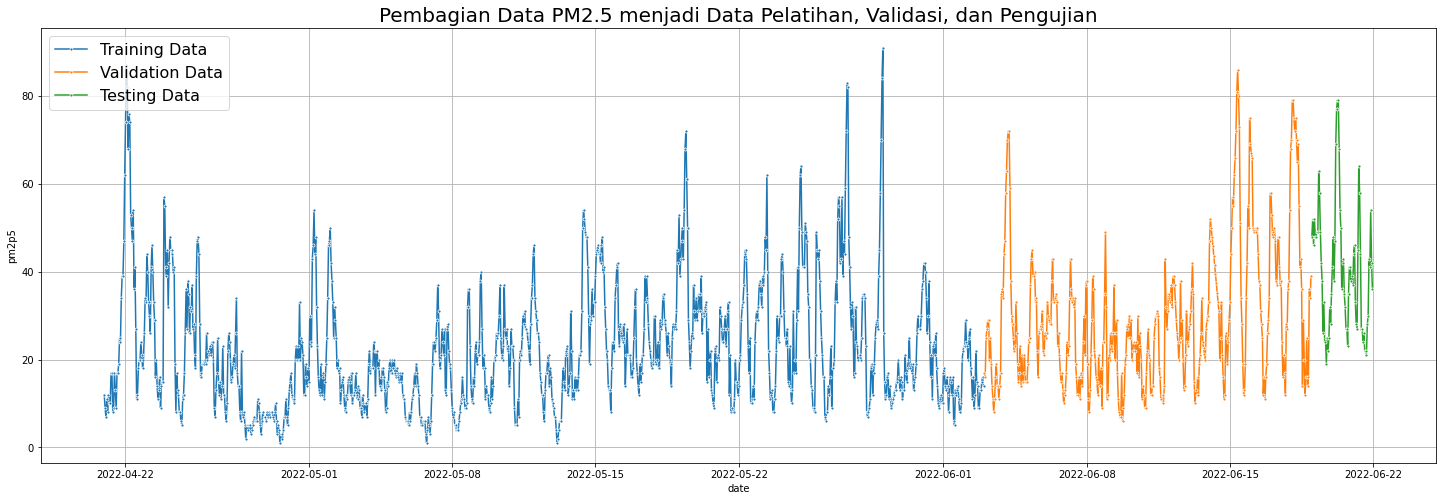

In [24]:
from turtle import color


plt.subplots(figsize = (25,8))
sns.lineplot(x="date", y="pm2p5",
             data=data_train, marker='.', label='Training Data')
sns.lineplot(x="date", y="pm2p5",
             data=data_val, marker='.', label='Validation Data')
sns.lineplot(x="date", y="pm2p5",
             data=data_test, marker='.', label='Testing Data')
plt.title("Pembagian Data PM2.5 menjadi Data Pelatihan, Validasi, dan Pengujian", fontsize = 20)
plt.legend(loc='upper left', prop={'size': 16})
plt.grid()

In [25]:
pm2p5 = dataset["pm2p5"].values.reshape(-1, 1)

pm2p5_train = data_train.values.reshape(-1, 1)

pm2p5_val = data_val.values.reshape(-1, 1)

pm2p5_test = data_test.values.reshape(-1, 1)

print(pm2p5_train.shape);print(pm2p5_val.shape);print(pm2p5_test.shape)

(1032, 1)
(384, 1)
(72, 1)


In [26]:
x_train = []
y_train = []

for i in range(n_lookback, len(pm2p5_train) - n_forecast + 1):
    x_train.append(pm2p5_train[i - n_lookback: i])
    y_train.append(pm2p5_train[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(985, 24, 1)
(985, 24, 1)


In [27]:
print(x_train[0]);print(y_train[0])

[[12.]
 [ 9.]
 [ 7.]
 [11.]
 [ 8.]
 [12.]
 [10.]
 [10.]
 [17.]
 [17.]
 [ 8.]
 [ 9.]
 [17.]
 [13.]
 [ 9.]
 [17.]
 [17.]
 [19.]
 [25.]
 [24.]
 [34.]
 [39.]
 [39.]
 [47.]]
[[62.]
 [74.]
 [87.]
 [82.]
 [68.]
 [76.]
 [74.]
 [53.]
 [50.]
 [47.]
 [54.]
 [36.]
 [41.]
 [27.]
 [11.]
 [12.]
 [18.]
 [20.]
 [20.]
 [24.]
 [21.]
 [18.]
 [20.]
 [26.]]


In [28]:
x_val = []
y_val = []

for i in range(n_lookback, len(pm2p5_val) - n_forecast + 1):
    x_val.append(pm2p5_val[i - n_lookback: i])
    y_val.append(pm2p5_val[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(337, 24, 1)
(337, 24, 1)


In [29]:
print(x_val[-1]);print(y_val[-1])

[[58.]
 [53.]
 [48.]
 [49.]
 [50.]
 [47.]
 [38.]
 [37.]
 [48.]
 [48.]
 [41.]
 [37.]
 [38.]
 [24.]
 [16.]
 [21.]
 [17.]
 [12.]
 [28.]
 [27.]
 [36.]
 [38.]
 [54.]
 [68.]]
[[70.]
 [79.]
 [79.]
 [75.]
 [72.]
 [75.]
 [70.]
 [65.]
 [69.]
 [55.]
 [41.]
 [43.]
 [36.]
 [14.]
 [29.]
 [20.]
 [12.]
 [16.]
 [25.]
 [14.]
 [16.]
 [36.]
 [34.]
 [39.]]


## Scaling / Normalize Data

In [30]:
pm2p5_train_scaled = normalize_series(pm2p5_train, Average(pm2p5_train), stdev(pm2p5_train.flatten()))

pm2p5_val_scaled = normalize_series(pm2p5_val, Average(pm2p5_val), stdev(pm2p5_val.flatten()))

pm2p5_test_scaled = normalize_series(pm2p5_test, Average(pm2p5_test), stdev(pm2p5_test.flatten()))

## Set feature and label period

In [31]:
x_train_scaled = []
y_train_scaled = []

for i in range(n_lookback, len(pm2p5_train_scaled) - n_forecast + 1):
    x_train_scaled.append(pm2p5_train_scaled[i - n_lookback: i])
    y_train_scaled.append(pm2p5_train_scaled[i: i + n_forecast])

x_train_scaled = np.array(x_train_scaled)
y_train_scaled = np.array(y_train_scaled)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(985, 24, 1)
(985, 24, 1)


In [32]:
x_val_scaled = []
y_val_scaled = []

for i in range(n_lookback, len(pm2p5_val_scaled) - n_forecast + 1):
    x_val_scaled.append(pm2p5_val_scaled[i - n_lookback: i])
    y_val_scaled.append(pm2p5_val_scaled[i: i + n_forecast])

x_val_scaled = np.array(x_val_scaled)
y_val_scaled = np.array(y_val_scaled)
print(x_val_scaled.shape)
print(y_val_scaled.shape)

(337, 24, 1)
(337, 24, 1)


# Vanilla LSTM

## Read Model

In [33]:
modelVanillaLSTM = tf.keras.models.load_model('./Models/UnivariateForecast_VanillaLSTM-Model.h5')

In [34]:
y_val_pred = modelVanillaLSTM.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 1ms/step
(337, 24)


In [199]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = modelVanillaLSTM.evaluate(x_train_scaled, y_train_scaled, batch_size=8)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = modelVanillaLSTM.evaluate(x_val_scaled, y_val_scaled, batch_size=8)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
124/124 [==============================] - 0s 2ms/step - loss: 0.3081 - mse: 0.7522
train loss, train mse: [0.3081 0.7522]
Evaluate on val data
43/43 [==============================] - 0s 1ms/step - loss: 0.3152 - mse: 0.7643
val loss, val mse: [0.3152 0.7643]


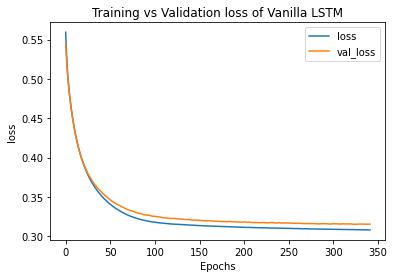

342


In [36]:
with open('./Models/historyVanillaLSTM', "rb") as file_pi:
    load_historyVanillaLSTM = pickle.load(file_pi)

plot_graphs(load_historyVanillaLSTM, "loss", "Vanilla LSTM")
print(len(load_historyVanillaLSTM['loss']))

## Prediction

### Prediction with training data

In [37]:
forecast_train_data = model_forecast(modelVanillaLSTM, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1009/1009 [==============================] - 2s 2ms/step
(1009, 24)
(1008,)
1008


In [38]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([38.99321552, 45.82495685, 54.3512897 , 64.07635684, 66.87756152])

In [39]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [40]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  38.993216
1    2022-04-22 01:00:00    74.0  45.824957
2    2022-04-22 02:00:00    87.0  54.351290
3    2022-04-22 03:00:00    82.0  64.076357
4    2022-04-22 04:00:00    68.0  66.877562
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  11.958651
1004 2022-06-02 20:00:00    13.0  13.433426
1005 2022-06-02 21:00:00    15.0  14.935587
1006 2022-06-02 22:00:00    16.0  15.744330
1007 2022-06-02 23:00:00    14.0  16.419851

[1008 rows x 3 columns]

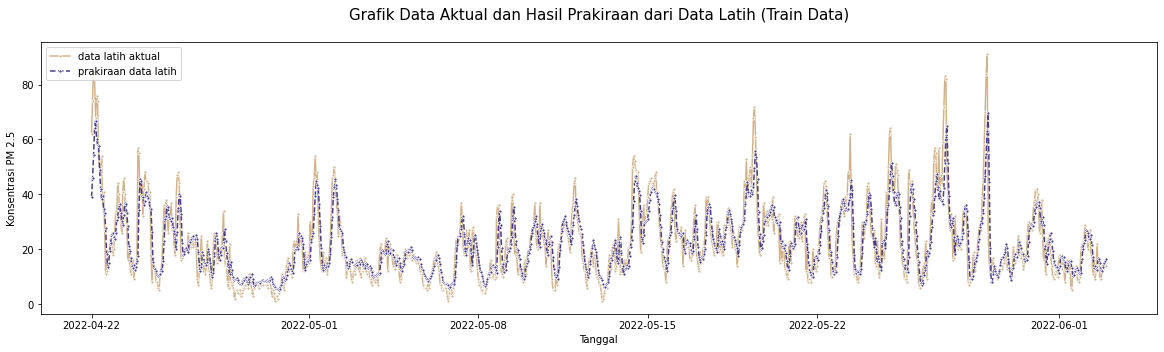

In [41]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [42]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  7.34
MAE:  5.24
MAPE:  0.2542


### Prediction with validation data

In [43]:
forecast_val_data = model_forecast(modelVanillaLSTM, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 0s 1ms/step
(361, 24)
(360,)
360


In [44]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([40.14971256, 44.11700058, 50.16154671, 54.45280266, 58.19766617])

In [45]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [46]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  40.149713
1   2022-06-04 01:00:00    58.0  44.117001
2   2022-06-04 02:00:00    63.0  50.161547
3   2022-06-04 03:00:00    70.0  54.452803
4   2022-06-04 04:00:00    72.0  58.197666
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  23.049200
356 2022-06-18 20:00:00    16.0  22.369074
357 2022-06-18 21:00:00    36.0  21.666922
358 2022-06-18 22:00:00    34.0  30.218915
359 2022-06-18 23:00:00    39.0  35.652884

[360 rows x 3 columns]

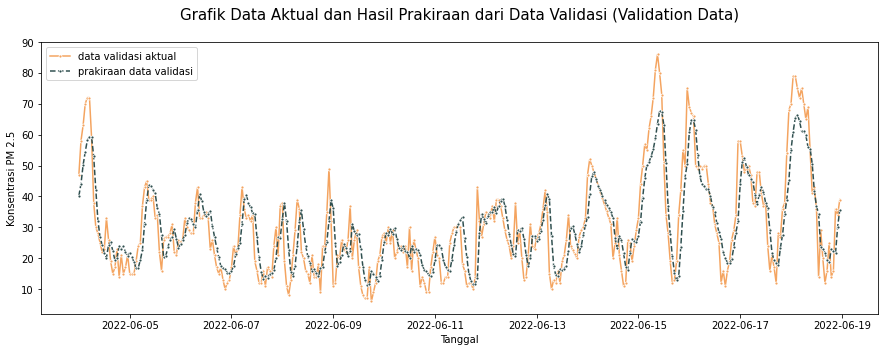

In [47]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [48]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  8.43
MAE:  6.59
MAPE:  0.2442


### Prediction with test data

In [49]:
forecast_test_data = model_forecast(modelVanillaLSTM, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 1ms/step
(49, 24)
(48,)
48


In [50]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([34.90197123, 39.38679899, 46.46080865, 44.9073037 , 47.04885949])

In [51]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [52]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  34.901971
1  2022-06-20 01:00:00    48.0  39.386799
2  2022-06-20 02:00:00    38.0  46.460809
3  2022-06-20 03:00:00    47.0  44.907304
4  2022-06-20 04:00:00    69.0  47.048859
5  2022-06-20 05:00:00    77.0  55.871911
6  2022-06-20 06:00:00    79.0  65.068484
7  2022-06-20 07:00:00    79.0  69.448222
8  2022-06-20 08:00:00    68.0  68.641652
9  2022-06-20 09:00:00    54.0  64.044833
10 2022-06-20 10:00:00    50.0  55.467145
11 2022-06-20 11:00:00    36.0  49.762787
12 2022-06-20 12:00:00    42.0  40.587848
13 2022-06-20 13:00:00    43.0  38.634666
14 2022-06-20 14:00:00    35.0  38.955708
15 2022-06-20 15:00:00    32.0  36.281880
16 2022-06-20 16:00:00    27.0  32.101560
17 2022-06-20 17:00:00    27.0  27.737274
18 2022-06-20 18:00:00    23.0  26.222061
19 2022-06-20 19:00:00    35.0  25.507427
20 2022-06-20 20:00:00    41.0  30.635113
21 2022-06-20 21:00:00    41.0  37.769492
22 2022-06-20 22:00:00    38.0  42.922323
23 2022-06-20 23:00:00    39.0  43.261346
24 2022-06-21 00:00:00    37.0  42.791432
25 2022-06-21 01:00:00    44.0  42.280278
26 2022-06-21 02:00:00    46.0  46.188339
27 2022-06-21 03:00:00    33.0  48.572030
28 2022-06-21 04:00:00    28.0  41.377700
29 2022-06-21 05:00:00    27.0  33.062455
30 2022-06-21 06:00:00    45.0  27.308846
31 2022-06-21 07:00:00    64.0  34.344326
32 2022-06-21 08:00:00    58.0  48.325520
33 2022-06-21 09:00:00    44.0  55.371657
34 2022-06-21 10:00:00    27.0  51.177288
35 2022-06-21 11:00:00    27.0  39.103005
36 2022-06-21 12:00:00    24.0  30.654773
37 2022-06-21 13:00:00    26.0  26.773880
38 2022-06-21 14:00:00    22.0  27.039557
39 2022-06-21 15:00:00    22.0  25.740119
40 2022-06-21 16:00:00    21.0  24.247334
41 2022-06-21 17:00:00    28.0  23.536506
42 2022-06-21 18:00:00    30.0  25.817407
43 2022-06-21 19:00:00    43.0  28.717844
44 2022-06-21 20:00:00    41.0  37.057294
45 2022-06-21 21:00:00    54.0  42.784028
46 2022-06-21 22:00:00    42.0  50.362900
47 2022-06-21 23:00:00    36.0  48.929485

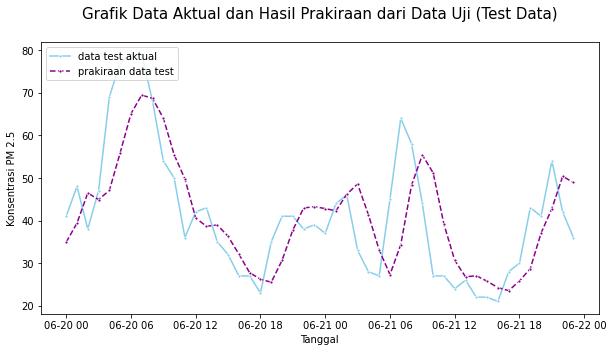

In [53]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [54]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  10.63
MAE:  8.4
MAPE:  0.2106


## Summary Eval Metric

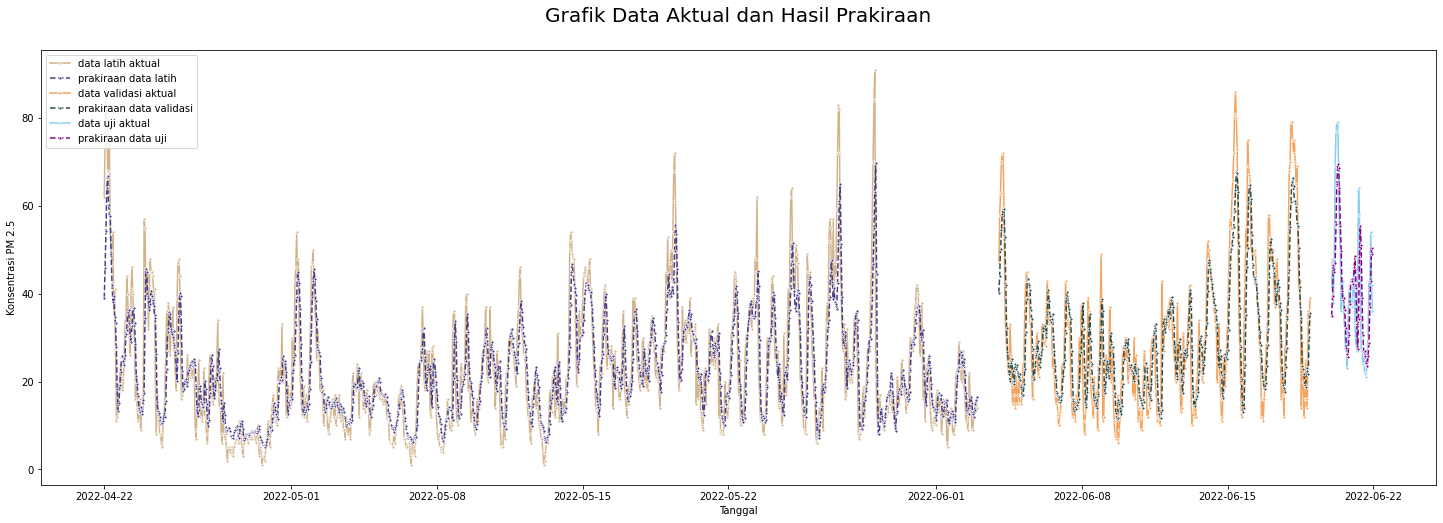

In [55]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [56]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  7.34
MAE:  5.24
MAPE:  0.2542
Forecast Val accuracy
RMSE:  8.43
MAE:  6.59
MAPE:  0.2442
Forecast Test accuracy
RMSE:  10.63
MAE:  8.4
MAPE:  0.2106


# 2Stacked LSTM

## Read Model

In [57]:
model2StackedLSTM = tf.keras.models.load_model('./Models/UnivariateForecast_2StackedLSTM-Model.h5')

In [58]:
y_val_pred = model2StackedLSTM.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 2ms/step
(337, 24)


In [59]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = model2StackedLSTM.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = model2StackedLSTM.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 0s 3ms/step - loss: 0.3234 - mse: 0.7759
train loss, train mse: [0.3234 0.7759]
Evaluate on val data
6/6 [==============================] - 0s 3ms/step - loss: 0.3274 - mse: 0.7810
val loss, val mse: [0.3274 0.781 ]


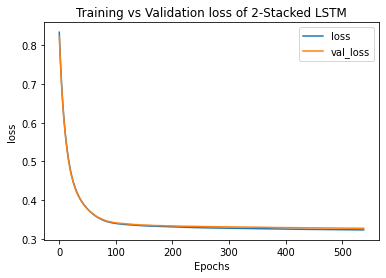

539


In [60]:
with open('./Models/history2StackedLSTM', "rb") as file_pi:
    load_history2StackedLSTM = pickle.load(file_pi)

plot_graphs(load_history2StackedLSTM, "loss", "2-Stacked LSTM")
print(len(load_history2StackedLSTM['loss']))

## Prediction

### Prediction with training data

In [61]:
forecast_train_data = model_forecast(model2StackedLSTM, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 2s 2ms/step
(1009, 24)
(1008,)
1008


In [62]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([34.22875114, 38.06083865, 43.53545184, 51.44850154, 58.09781833])

In [63]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [64]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  34.228751
1    2022-04-22 01:00:00    74.0  38.060839
2    2022-04-22 02:00:00    87.0  43.535452
3    2022-04-22 03:00:00    82.0  51.448502
4    2022-04-22 04:00:00    68.0  58.097818
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  14.484766
1004 2022-06-02 20:00:00    13.0  14.361476
1005 2022-06-02 21:00:00    15.0  14.858847
1006 2022-06-02 22:00:00    16.0  15.612593
1007 2022-06-02 23:00:00    14.0  16.545697

[1008 rows x 3 columns]

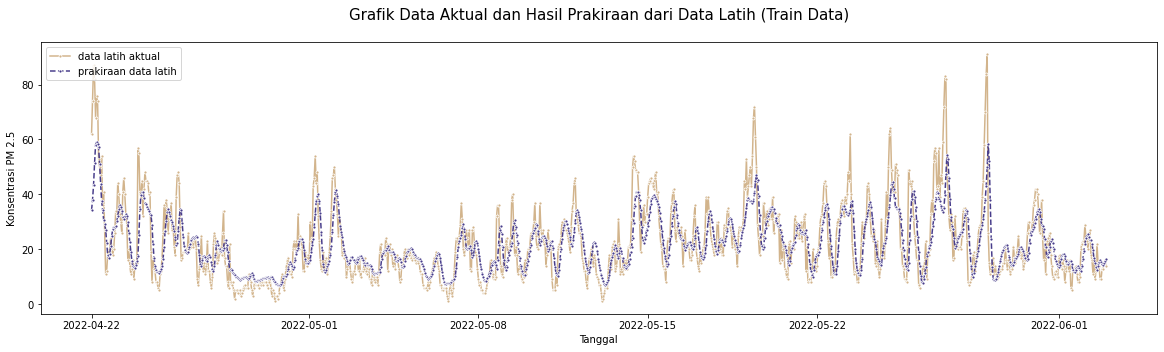

In [65]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [66]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  8.8
MAE:  6.28
MAPE:  0.2965


### Prediction with validation data

In [67]:
forecast_val_data = model_forecast(model2StackedLSTM, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 1s 2ms/step
(361, 24)
(360,)
360


In [68]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([36.38962269, 40.0335722 , 43.60997486, 46.96063232, 49.85685158])

In [69]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [70]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  36.389623
1   2022-06-04 01:00:00    58.0  40.033572
2   2022-06-04 02:00:00    63.0  43.609975
3   2022-06-04 03:00:00    70.0  46.960632
4   2022-06-04 04:00:00    72.0  49.856852
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  22.512673
356 2022-06-18 20:00:00    16.0  23.680234
357 2022-06-18 21:00:00    36.0  24.389214
358 2022-06-18 22:00:00    34.0  28.084129
359 2022-06-18 23:00:00    39.0  32.812633

[360 rows x 3 columns]

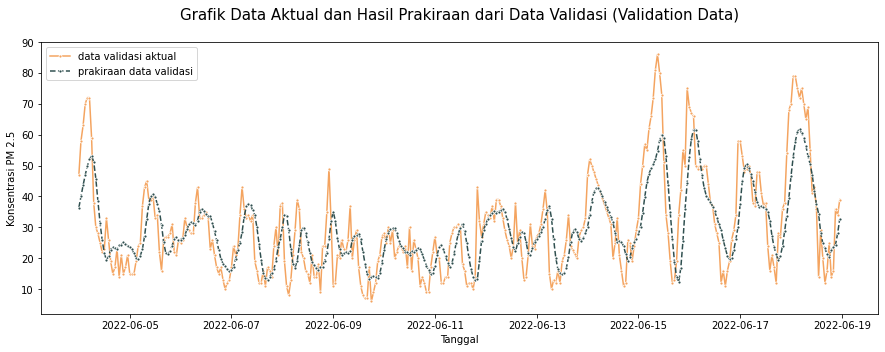

In [71]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [72]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  10.25
MAE:  7.87
MAPE:  0.2853


### Prediction with test data

In [73]:
forecast_test_data = model_forecast(model2StackedLSTM, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 3ms/step
(49, 24)
(48,)
48


In [74]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([34.54004849, 37.95349277, 42.5686108 , 44.57757748, 46.36019982])

In [75]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [76]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  34.540048
1  2022-06-20 01:00:00    48.0  37.953493
2  2022-06-20 02:00:00    38.0  42.568611
3  2022-06-20 03:00:00    47.0  44.577577
4  2022-06-20 04:00:00    69.0  46.360200
5  2022-06-20 05:00:00    77.0  50.568993
6  2022-06-20 06:00:00    79.0  55.942084
7  2022-06-20 07:00:00    79.0  60.408538
8  2022-06-20 08:00:00    68.0  62.998954
9  2022-06-20 09:00:00    54.0  62.370896
10 2022-06-20 10:00:00    50.0  58.258450
11 2022-06-20 11:00:00    36.0  52.885789
12 2022-06-20 12:00:00    42.0  45.890747
13 2022-06-20 13:00:00    43.0  40.474857
14 2022-06-20 14:00:00    35.0  37.445158
15 2022-06-20 15:00:00    32.0  35.014893
16 2022-06-20 16:00:00    27.0  32.652727
17 2022-06-20 17:00:00    27.0  30.230208
18 2022-06-20 18:00:00    23.0  28.509902
19 2022-06-20 19:00:00    35.0  27.695358
20 2022-06-20 20:00:00    41.0  29.522281
21 2022-06-20 21:00:00    41.0  33.902325
22 2022-06-20 22:00:00    38.0  38.908485
23 2022-06-20 23:00:00    39.0  42.173206
24 2022-06-21 00:00:00    37.0  43.977222
25 2022-06-21 01:00:00    44.0  44.403790
26 2022-06-21 02:00:00    46.0  45.390777
27 2022-06-21 03:00:00    33.0  46.306737
28 2022-06-21 04:00:00    28.0  44.142512
29 2022-06-21 05:00:00    27.0  39.667081
30 2022-06-21 06:00:00    45.0  34.857945
31 2022-06-21 07:00:00    64.0  34.401773
32 2022-06-21 08:00:00    58.0  40.138104
33 2022-06-21 09:00:00    44.0  46.378928
34 2022-06-21 10:00:00    27.0  48.713934
35 2022-06-21 11:00:00    27.0  44.843723
36 2022-06-21 12:00:00    24.0  38.269874
37 2022-06-21 13:00:00    26.0  32.417868
38 2022-06-21 14:00:00    22.0  28.857175
39 2022-06-21 15:00:00    22.0  26.632046
40 2022-06-21 16:00:00    21.0  25.383220
41 2022-06-21 17:00:00    28.0  24.645454
42 2022-06-21 18:00:00    30.0  25.473926
43 2022-06-21 19:00:00    43.0  27.571552
44 2022-06-21 20:00:00    41.0  32.519587
45 2022-06-21 21:00:00    54.0  37.876080
46 2022-06-21 22:00:00    42.0  43.972350
47 2022-06-21 23:00:00    36.0  46.810764

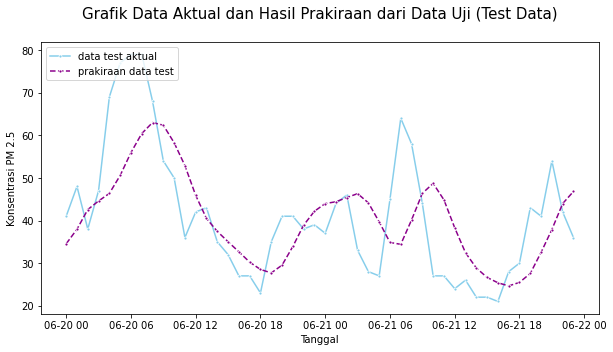

In [77]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [78]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  11.95
MAE:  9.5
MAPE:  0.2372


## Summary Eval Metric

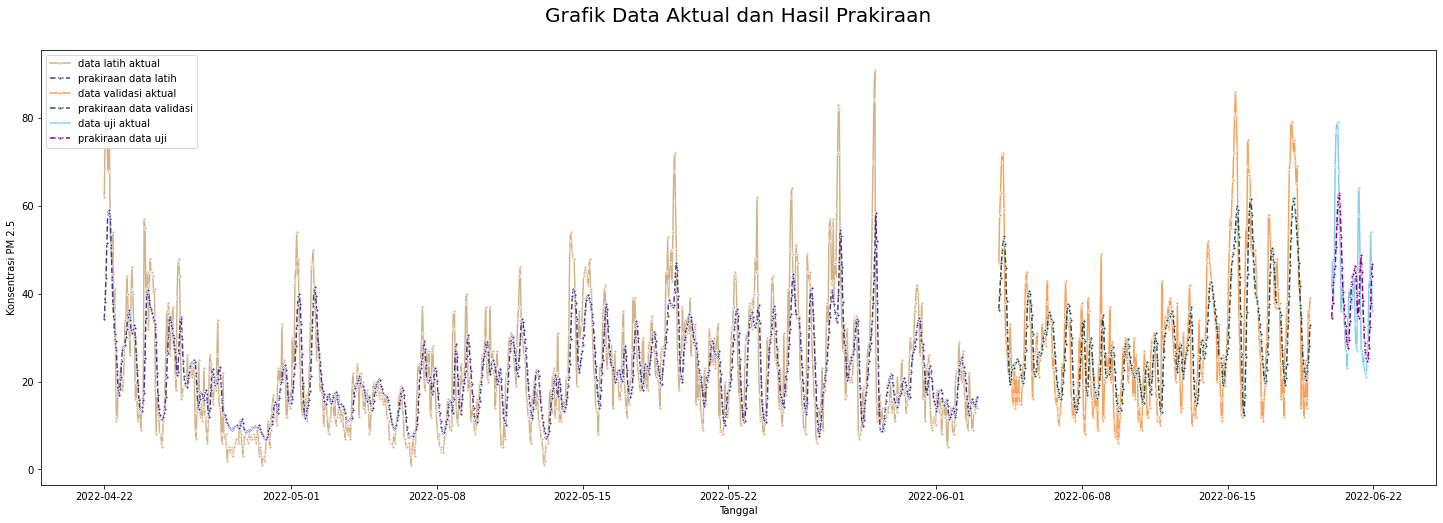

In [79]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [80]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  8.8
MAE:  6.28
MAPE:  0.2965
Forecast Val accuracy
RMSE:  10.25
MAE:  7.87
MAPE:  0.2853
Forecast Test accuracy
RMSE:  11.95
MAE:  9.5
MAPE:  0.2372


# 3Stacked LSTM

## Read Model

In [81]:
model3StackedLSTM = tf.keras.models.load_model('./Models/UnivariateForecast_3StackedLSTM-Model.h5')

In [82]:
y_val_pred = model3StackedLSTM.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 4ms/step
(337, 24)


In [83]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = model3StackedLSTM.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = model3StackedLSTM.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 0s 5ms/step - loss: 0.3449 - mse: 0.8235
train loss, train mse: [0.3449 0.8235]
Evaluate on val data
6/6 [==============================] - 0s 5ms/step - loss: 0.3395 - mse: 0.7996
val loss, val mse: [0.3395 0.7996]


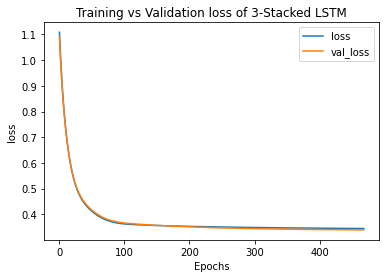

469


In [84]:
with open('./Models/history3StackedLSTM', "rb") as file_pi:
    load_history3StackedLSTM = pickle.load(file_pi)

plot_graphs(load_history3StackedLSTM, "loss", "3-Stacked LSTM")
print(len(load_history3StackedLSTM['loss']))

## Prediction

### Prediction with training data

In [85]:
forecast_train_data = model_forecast(model3StackedLSTM, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 3s 3ms/step
(1009, 24)
(1008,)
1008


In [86]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([25.2229497 , 27.30979534, 29.20756622, 30.65211387, 31.41685672])

In [87]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [88]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  25.222950
1    2022-04-22 01:00:00    74.0  27.309795
2    2022-04-22 02:00:00    87.0  29.207566
3    2022-04-22 03:00:00    82.0  30.652114
4    2022-04-22 04:00:00    68.0  31.416857
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  16.354791
1004 2022-06-02 20:00:00    13.0  16.863868
1005 2022-06-02 21:00:00    15.0  17.369715
1006 2022-06-02 22:00:00    16.0  17.883060
1007 2022-06-02 23:00:00    14.0  18.216769

[1008 rows x 3 columns]

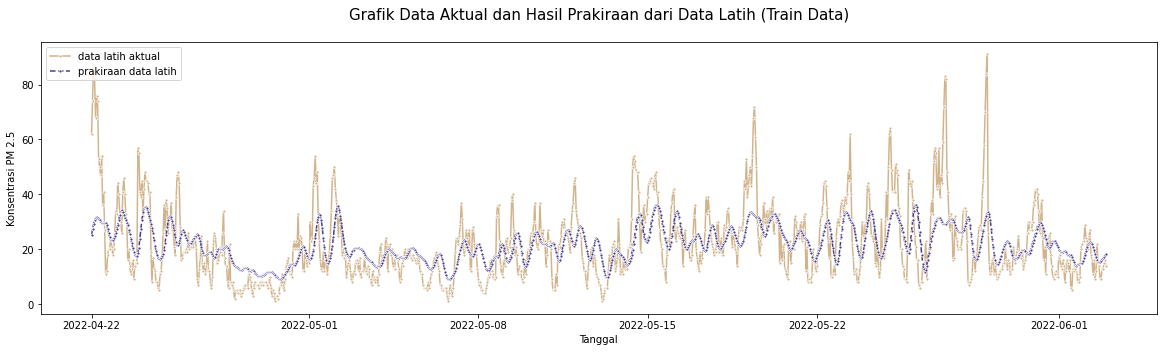

In [89]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [90]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  11.1
MAE:  8.09
MAPE:  0.3696


### Prediction with validation data

In [91]:
forecast_val_data = model_forecast(model3StackedLSTM, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 1s 3ms/step
(361, 24)
(360,)
360


In [92]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([28.44455469, 31.47279441, 34.34200621, 36.62048817, 38.39282799])

In [93]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [94]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  28.444555
1   2022-06-04 01:00:00    58.0  31.472794
2   2022-06-04 02:00:00    63.0  34.342006
3   2022-06-04 03:00:00    70.0  36.620488
4   2022-06-04 04:00:00    72.0  38.392828
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  27.162919
356 2022-06-18 20:00:00    16.0  27.018239
357 2022-06-18 21:00:00    36.0  27.067220
358 2022-06-18 22:00:00    34.0  28.080581
359 2022-06-18 23:00:00    39.0  29.798857

[360 rows x 3 columns]

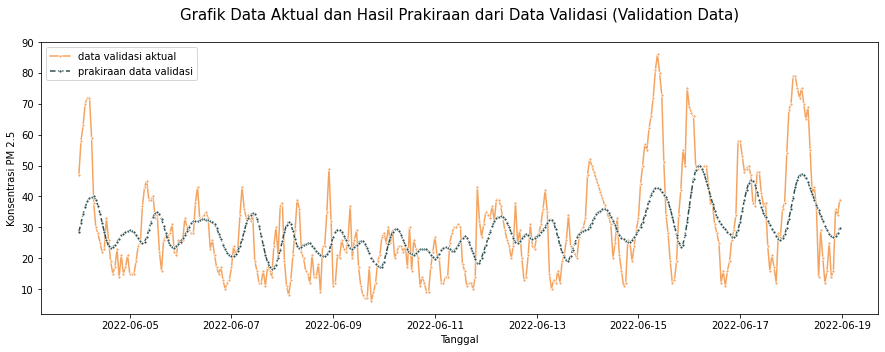

In [95]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [96]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  12.97
MAE:  9.76
MAPE:  0.3337


### Prediction with test data

In [97]:
forecast_test_data = model_forecast(model3StackedLSTM, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 4ms/step
(49, 24)
(48,)
48


In [98]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([34.30243243, 36.28415383, 38.73197819, 41.28534348, 43.41228665])

In [99]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [100]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  34.302432
1  2022-06-20 01:00:00    48.0  36.284154
2  2022-06-20 02:00:00    38.0  38.731978
3  2022-06-20 03:00:00    47.0  41.285343
4  2022-06-20 04:00:00    69.0  43.412287
5  2022-06-20 05:00:00    77.0  45.675514
6  2022-06-20 06:00:00    79.0  47.946086
7  2022-06-20 07:00:00    79.0  49.991568
8  2022-06-20 08:00:00    68.0  51.468405
9  2022-06-20 09:00:00    54.0  51.872339
10 2022-06-20 10:00:00    50.0  51.287873
11 2022-06-20 11:00:00    36.0  49.896915
12 2022-06-20 12:00:00    42.0  47.527454
13 2022-06-20 13:00:00    43.0  44.543414
14 2022-06-20 14:00:00    35.0  41.802942
15 2022-06-20 15:00:00    32.0  38.987640
16 2022-06-20 16:00:00    27.0  36.764963
17 2022-06-20 17:00:00    27.0  34.857052
18 2022-06-20 18:00:00    23.0  33.556127
19 2022-06-20 19:00:00    35.0  32.478080
20 2022-06-20 20:00:00    41.0  32.342731
21 2022-06-20 21:00:00    41.0  33.281160
22 2022-06-20 22:00:00    38.0  35.082479
23 2022-06-20 23:00:00    39.0  37.614855
24 2022-06-21 00:00:00    37.0  40.169011
25 2022-06-21 01:00:00    44.0  42.337873
26 2022-06-21 02:00:00    46.0  44.084866
27 2022-06-21 03:00:00    33.0  45.809097
28 2022-06-21 04:00:00    28.0  46.495321
29 2022-06-21 05:00:00    27.0  45.806048
30 2022-06-21 06:00:00    45.0  44.016473
31 2022-06-21 07:00:00    64.0  42.056889
32 2022-06-21 08:00:00    58.0  41.050504
33 2022-06-21 09:00:00    44.0  41.229898
34 2022-06-21 10:00:00    27.0  41.918848
35 2022-06-21 11:00:00    27.0  42.025092
36 2022-06-21 12:00:00    24.0  41.490471
37 2022-06-21 13:00:00    26.0  39.729356
38 2022-06-21 14:00:00    22.0  37.365883
39 2022-06-21 15:00:00    22.0  35.052304
40 2022-06-21 16:00:00    21.0  32.910291
41 2022-06-21 17:00:00    28.0  31.209077
42 2022-06-21 18:00:00    30.0  30.197858
43 2022-06-21 19:00:00    43.0  30.130056
44 2022-06-21 20:00:00    41.0  30.978593
45 2022-06-21 21:00:00    54.0  32.720522
46 2022-06-21 22:00:00    42.0  35.534754
47 2022-06-21 23:00:00    36.0  38.695576

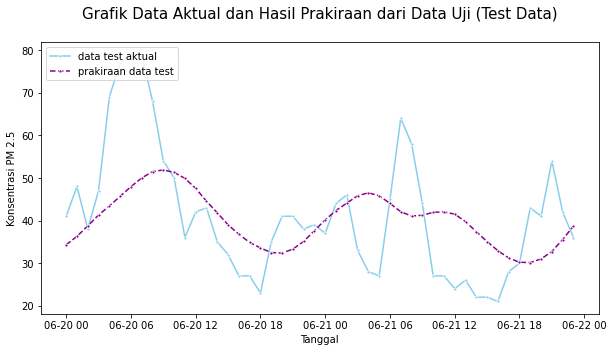

In [101]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [102]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  13.39
MAE:  10.53
MAPE:  0.2605


## Summary Eval Metric

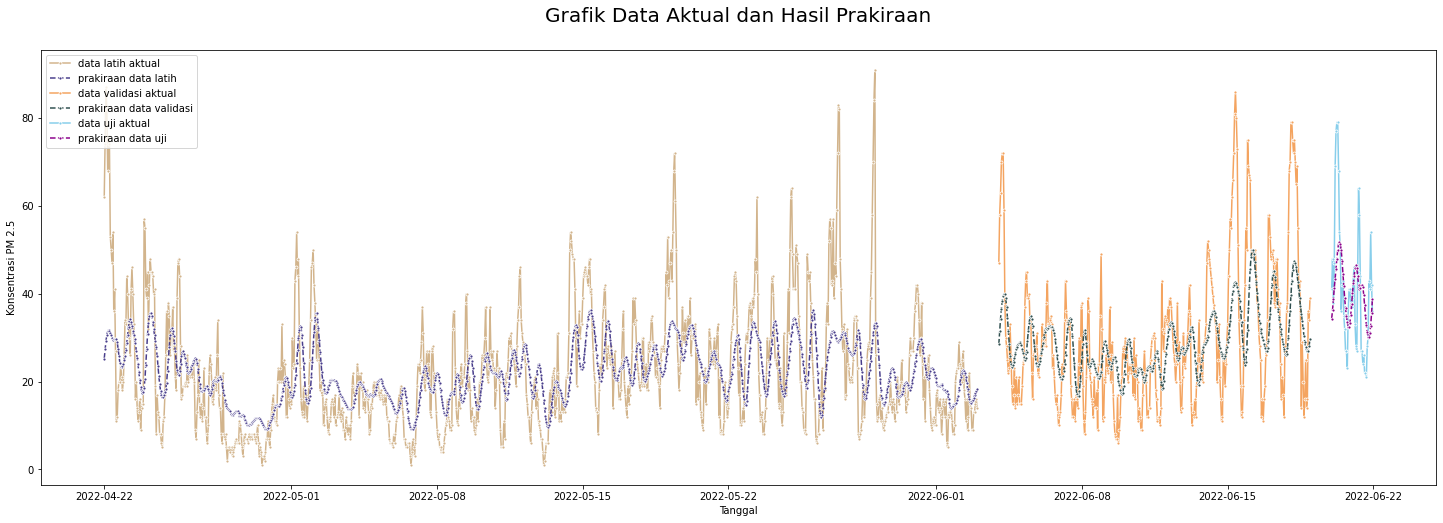

In [103]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [104]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  11.1
MAE:  8.09
MAPE:  0.3696
Forecast Val accuracy
RMSE:  12.97
MAE:  9.76
MAPE:  0.3337
Forecast Test accuracy
RMSE:  13.39
MAE:  10.53
MAPE:  0.2605


# Biderectional LSTM

## Read Model

In [105]:
modelBiLSTM = tf.keras.models.load_model('./Models/UnivariateForecast_BiLSTM-Model.h5')

In [106]:
y_val_pred = modelBiLSTM.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 2ms/step
(337, 24)


In [107]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = modelBiLSTM.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = modelBiLSTM.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 0s 2ms/step - loss: 0.3067 - mse: 0.7491
train loss, train mse: [0.3067 0.7491]
Evaluate on val data
6/6 [==============================] - 0s 2ms/step - loss: 0.3149 - mse: 0.7636
val loss, val mse: [0.3149 0.7636]


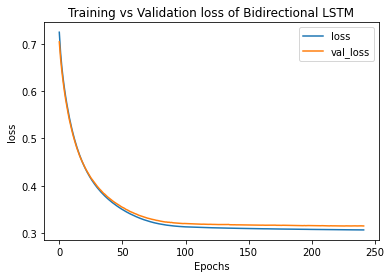

242


In [108]:
with open('./Models/historyBiLSTM', "rb") as file_pi:
    load_historyBiLSTM = pickle.load(file_pi)

plot_graphs(load_historyBiLSTM, "loss", "Bidirectional LSTM")
print(len(load_historyBiLSTM['loss']))

## Prediction

### Prediction with training data

In [109]:
forecast_train_data = model_forecast(modelBiLSTM, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 2s 2ms/step
(1009, 24)
(1008,)
1008


In [110]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([39.49061008, 46.55804057, 54.80381961, 63.99243732, 66.26866718])

In [111]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [112]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  39.490610
1    2022-04-22 01:00:00    74.0  46.558041
2    2022-04-22 02:00:00    87.0  54.803820
3    2022-04-22 03:00:00    82.0  63.992437
4    2022-04-22 04:00:00    68.0  66.268667
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  11.336765
1004 2022-06-02 20:00:00    13.0  13.515538
1005 2022-06-02 21:00:00    15.0  14.626648
1006 2022-06-02 22:00:00    16.0  15.832622
1007 2022-06-02 23:00:00    14.0  16.337283

[1008 rows x 3 columns]

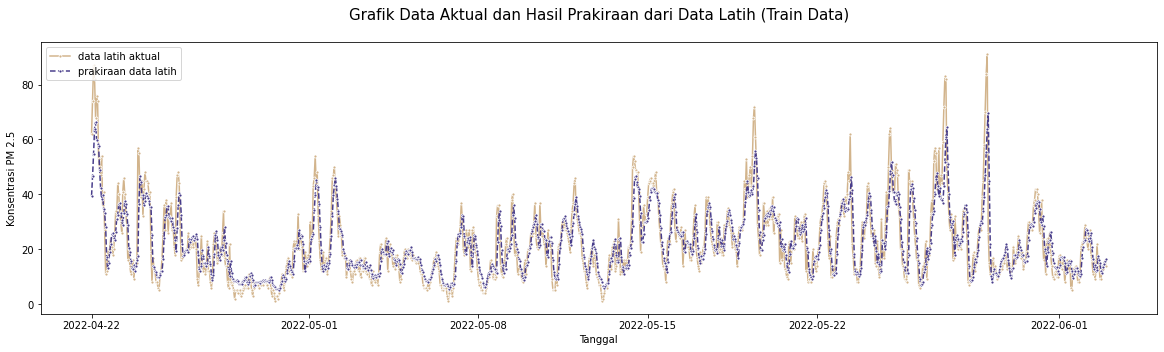

In [113]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [114]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  7.2
MAE:  5.11
MAPE:  0.2488


### Prediction with validation data

In [115]:
forecast_val_data = model_forecast(modelBiLSTM, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 1s 2ms/step
(361, 24)
(360,)
360


In [116]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([40.53355694, 44.33010197, 50.50502205, 55.01893425, 58.74072456])

In [117]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [118]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  40.533557
1   2022-06-04 01:00:00    58.0  44.330102
2   2022-06-04 02:00:00    63.0  50.505022
3   2022-06-04 03:00:00    70.0  55.018934
4   2022-06-04 04:00:00    72.0  58.740725
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  23.196261
356 2022-06-18 20:00:00    16.0  21.500151
357 2022-06-18 21:00:00    36.0  21.111006
358 2022-06-18 22:00:00    34.0  31.256344
359 2022-06-18 23:00:00    39.0  36.078137

[360 rows x 3 columns]

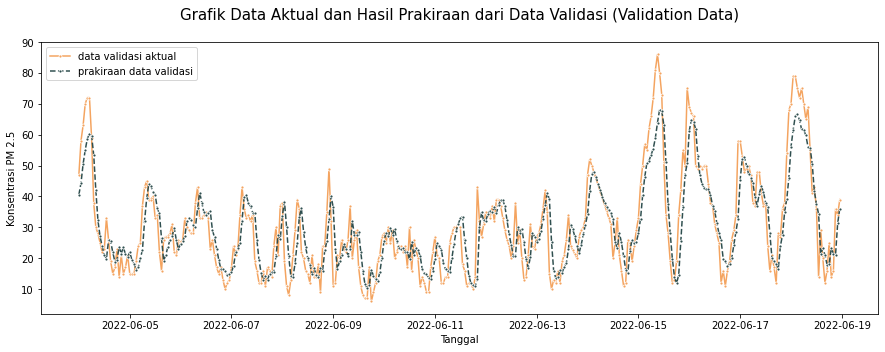

In [119]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [120]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  8.21
MAE:  6.36
MAPE:  0.2371


### Prediction with test data

In [121]:
forecast_test_data = model_forecast(modelBiLSTM, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 2ms/step
(49, 24)
(48,)
48


In [122]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([35.25772752, 40.30415419, 46.9790677 , 44.22345985, 47.15306891])

In [123]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [124]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  35.257728
1  2022-06-20 01:00:00    48.0  40.304154
2  2022-06-20 02:00:00    38.0  46.979068
3  2022-06-20 03:00:00    47.0  44.223460
4  2022-06-20 04:00:00    69.0  47.153069
5  2022-06-20 05:00:00    77.0  57.156789
6  2022-06-20 06:00:00    79.0  65.812358
7  2022-06-20 07:00:00    79.0  69.636489
8  2022-06-20 08:00:00    68.0  69.060079
9  2022-06-20 09:00:00    54.0  64.391477
10 2022-06-20 10:00:00    50.0  56.109604
11 2022-06-20 11:00:00    36.0  50.088660
12 2022-06-20 12:00:00    42.0  39.649195
13 2022-06-20 13:00:00    43.0  38.634322
14 2022-06-20 14:00:00    35.0  39.652630
15 2022-06-20 15:00:00    32.0  35.505564
16 2022-06-20 16:00:00    27.0  31.700881
17 2022-06-20 17:00:00    27.0  27.429366
18 2022-06-20 18:00:00    23.0  26.065075
19 2022-06-20 19:00:00    35.0  25.049361
20 2022-06-20 20:00:00    41.0  30.861094
21 2022-06-20 21:00:00    41.0  38.369589
22 2022-06-20 22:00:00    38.0  42.888856
23 2022-06-20 23:00:00    39.0  42.795705
24 2022-06-21 00:00:00    37.0  42.575065
25 2022-06-21 01:00:00    44.0  41.993738
26 2022-06-21 02:00:00    46.0  46.764650
27 2022-06-21 03:00:00    33.0  48.717149
28 2022-06-21 04:00:00    28.0  40.316331
29 2022-06-21 05:00:00    27.0  32.061565
30 2022-06-21 06:00:00    45.0  26.964979
31 2022-06-21 07:00:00    64.0  35.589710
32 2022-06-21 08:00:00    58.0  49.761817
33 2022-06-21 09:00:00    44.0  55.695991
34 2022-06-21 10:00:00    27.0  51.219885
35 2022-06-21 11:00:00    27.0  37.978405
36 2022-06-21 12:00:00    24.0  30.397607
37 2022-06-21 13:00:00    26.0  26.176681
38 2022-06-21 14:00:00    22.0  26.104525
39 2022-06-21 15:00:00    22.0  24.769944
40 2022-06-21 16:00:00    21.0  23.711093
41 2022-06-21 17:00:00    28.0  23.157514
42 2022-06-21 18:00:00    30.0  25.779966
43 2022-06-21 19:00:00    43.0  28.923228
44 2022-06-21 20:00:00    41.0  38.803171
45 2022-06-21 21:00:00    54.0  43.653288
46 2022-06-21 22:00:00    42.0  51.630413
47 2022-06-21 23:00:00    36.0  49.052172

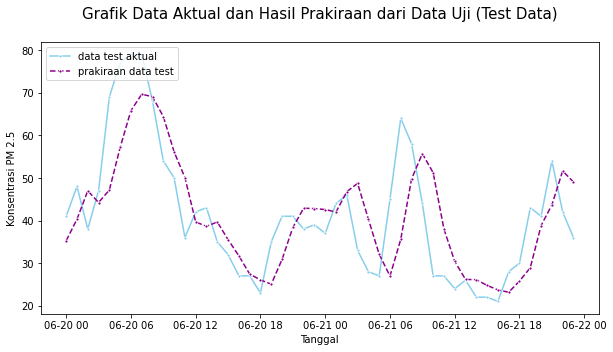

In [125]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [126]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  10.4
MAE:  8.19
MAPE:  0.2037


## Summary Eval Metric

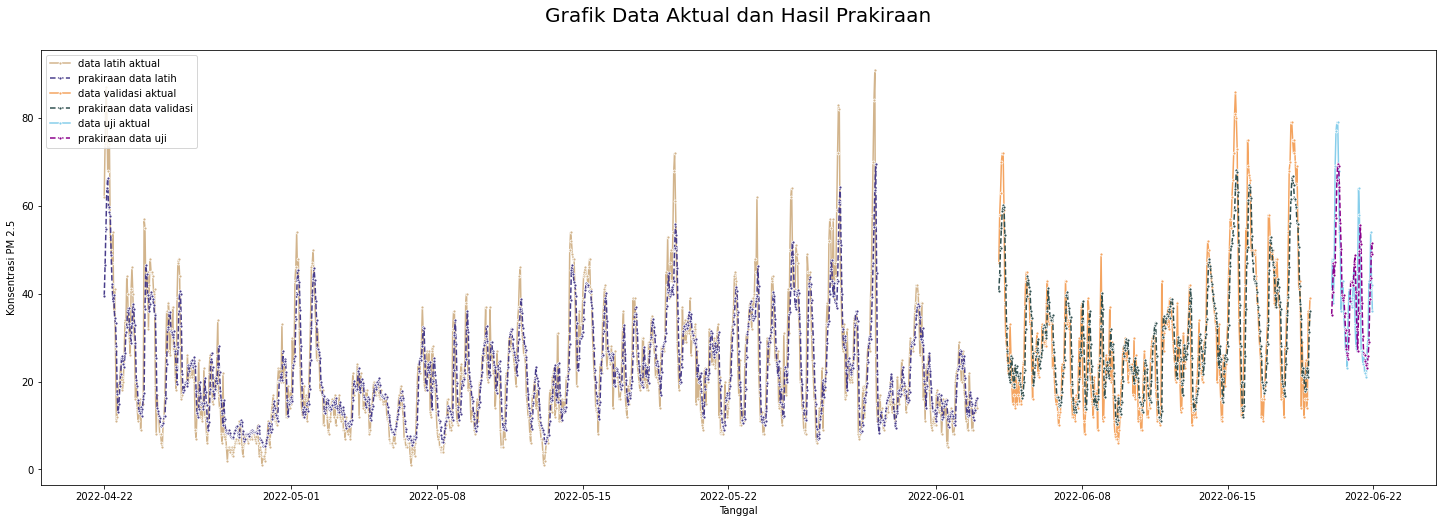

In [127]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [128]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  7.2
MAE:  5.11
MAPE:  0.2488
Forecast Val accuracy
RMSE:  8.21
MAE:  6.36
MAPE:  0.2371
Forecast Test accuracy
RMSE:  10.4
MAE:  8.19
MAPE:  0.2037


## Future Values

In [129]:
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%Y-%m-%d %H:%M') for dt in 
       datetime_range(datetime(2022, 6, 22, 0), datetime(2022, 6, 23, 0), 
       timedelta(minutes=60))]

# dts=np.array(dts)
print(dts)
print(np.shape(dts))

['2022-06-22 00:00', '2022-06-22 01:00', '2022-06-22 02:00', '2022-06-22 03:00', '2022-06-22 04:00', '2022-06-22 05:00', '2022-06-22 06:00', '2022-06-22 07:00', '2022-06-22 08:00', '2022-06-22 09:00', '2022-06-22 10:00', '2022-06-22 11:00', '2022-06-22 12:00', '2022-06-22 13:00', '2022-06-22 14:00', '2022-06-22 15:00', '2022-06-22 16:00', '2022-06-22 17:00', '2022-06-22 18:00', '2022-06-22 19:00', '2022-06-22 20:00', '2022-06-22 21:00', '2022-06-22 22:00', '2022-06-22 23:00']
(24,)


### with 24 data

In [130]:
pm2p5_scaled = normalize_series(pm2p5, Average(pm2p5), stdev(pm2p5_train.flatten()))

In [131]:
X_future = pm2p5_scaled[- n_lookback:].reshape(1, n_lookback, 1)
y_future = modelBiLSTM.predict(X_future)
print(y_future.shape)

y_future = inverse_normalize_series(y_future, Average(pm2p5), stdev(pm2p5_train.flatten()))
forecast_future_data = y_future[0]
print(forecast_future_data.shape)
print(forecast_future_data[:5])

1/1 [==============================] - 0s 15ms/step
(1, 24)
(24,)
[39.5952925  38.13828223 36.71020453 35.30818599 34.48104423]


In [132]:
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = dts
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = forecast_future_data
df_forecast

Date   Forecast
0  2022-06-22 00:00:00  39.595293
1  2022-06-22 01:00:00  38.138282
2  2022-06-22 02:00:00  36.710205
3  2022-06-22 03:00:00  35.308186
4  2022-06-22 04:00:00  34.481044
5  2022-06-22 05:00:00  32.849327
6  2022-06-22 06:00:00  30.883007
7  2022-06-22 07:00:00  28.982769
8  2022-06-22 08:00:00  26.641430
9  2022-06-22 09:00:00  24.065074
10 2022-06-22 10:00:00  23.258226
11 2022-06-22 11:00:00  22.794656
12 2022-06-22 12:00:00  22.716329
13 2022-06-22 13:00:00  23.833070
14 2022-06-22 14:00:00  24.605590
15 2022-06-22 15:00:00  25.103928
16 2022-06-22 16:00:00  25.631261
17 2022-06-22 17:00:00  27.443173
18 2022-06-22 18:00:00  28.611530
19 2022-06-22 19:00:00  29.805840
20 2022-06-22 20:00:00  30.127369
21 2022-06-22 21:00:00  29.882952
22 2022-06-22 22:00:00  30.070891
23 2022-06-22 23:00:00  30.155207

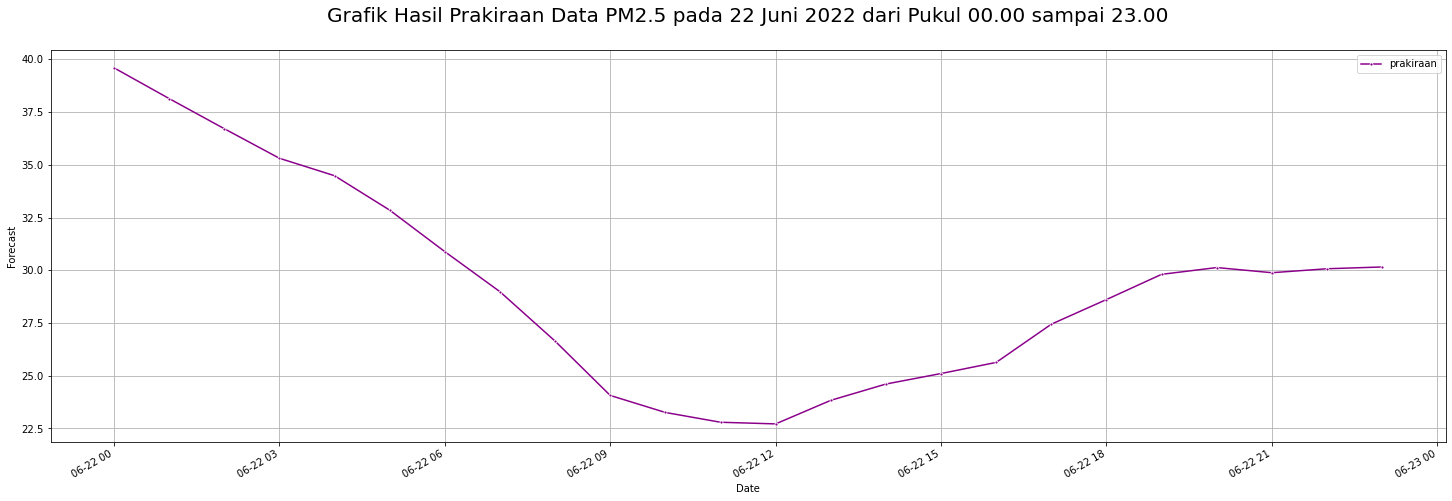

In [133]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="prakiraan", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Grafik Hasil Prakiraan Data PM2.5 pada 22 Juni 2022 dari Pukul 00.00 sampai 23.00\n", fontsize = 20)
plt.grid()

Text(0.5, 1.0, 'Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n')

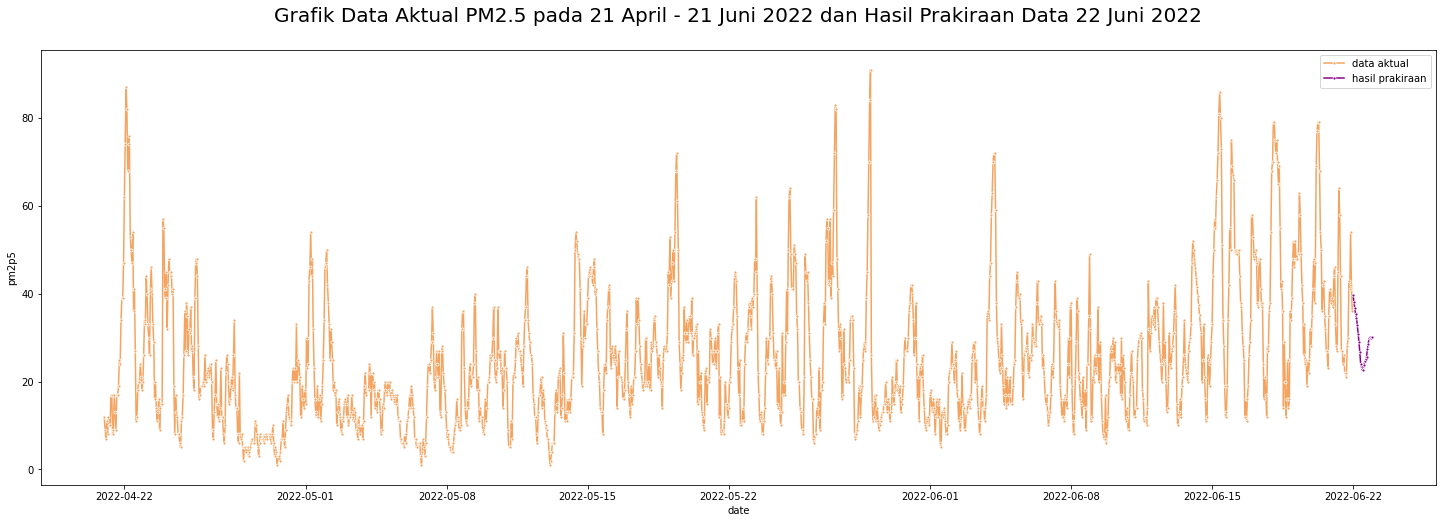

In [134]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="data aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="hasil prakiraan", marker='.', color='darkmagenta')
plt.title("Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n", fontsize = 20)

### with all data method I

In [135]:
# X_ = pm2p5_scaled[-2*n_lookback:]
X_future = []

for i in range(n_lookback, len(pm2p5_scaled)+1):
    X_future.append(pm2p5_scaled[i - n_lookback: i])
    # y_train.append(pm2p5_train[i: i + n_forecast])

X_future = np.array(X_future)
print(X_future.shape)
# print(X_future[-1])

(1465, 24, 1)


In [136]:
y_future = modelBiLSTM.predict(X_future)
print(y_future.shape)

y_future = inverse_normalize_series(y_future, Average(pm2p5), stdev(pm2p5_train.flatten()))
forecast_future_data = y_future[-1]
print(forecast_future_data.shape)
print(forecast_future_data[:5])

46/46 [==============================] - 0s 2ms/step
(1465, 24)
(24,)
[39.59529441 38.13828223 36.71020358 35.30818599 34.48104232]


In [137]:
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = dts
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = np.round(forecast_future_data, 3)
df_forecast

Date  Forecast
0  2022-06-22 00:00:00    39.595
1  2022-06-22 01:00:00    38.138
2  2022-06-22 02:00:00    36.710
3  2022-06-22 03:00:00    35.308
4  2022-06-22 04:00:00    34.481
5  2022-06-22 05:00:00    32.849
6  2022-06-22 06:00:00    30.883
7  2022-06-22 07:00:00    28.983
8  2022-06-22 08:00:00    26.641
9  2022-06-22 09:00:00    24.065
10 2022-06-22 10:00:00    23.258
11 2022-06-22 11:00:00    22.795
12 2022-06-22 12:00:00    22.716
13 2022-06-22 13:00:00    23.833
14 2022-06-22 14:00:00    24.606
15 2022-06-22 15:00:00    25.104
16 2022-06-22 16:00:00    25.631
17 2022-06-22 17:00:00    27.443
18 2022-06-22 18:00:00    28.612
19 2022-06-22 19:00:00    29.806
20 2022-06-22 20:00:00    30.127
21 2022-06-22 21:00:00    29.883
22 2022-06-22 22:00:00    30.071
23 2022-06-22 23:00:00    30.155

In [138]:
df_forecast.describe()

Forecast
count  24.000000
mean   29.237208
std     4.948489
min    22.716000
25%    24.979500
50%    29.394500
75%    31.374500
max    39.595000

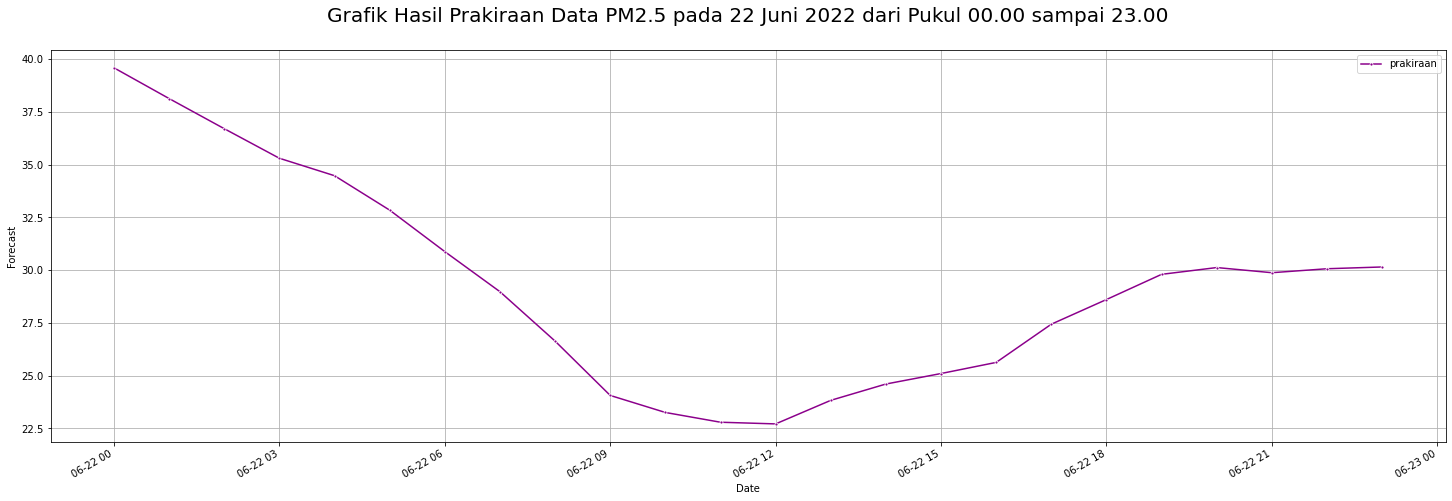

In [139]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="prakiraan", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Grafik Hasil Prakiraan Data PM2.5 pada 22 Juni 2022 dari Pukul 00.00 sampai 23.00\n", fontsize = 20)
plt.grid()

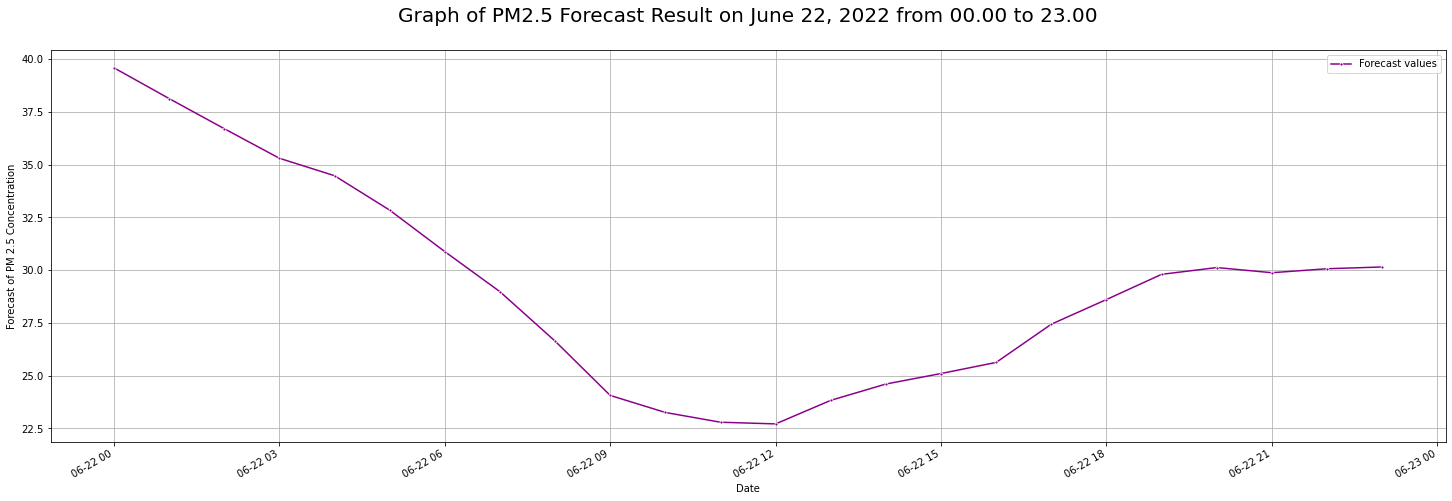

In [140]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="Forecast values", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Graph of PM2.5 Forecast Result on June 22, 2022 from 00.00 to 23.00\n", fontsize = 20)
plt.xlabel('Date'); plt.ylabel('Forecast of PM 2.5 Concentration')
plt.grid()

Text(0.5, 1.0, 'Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n')

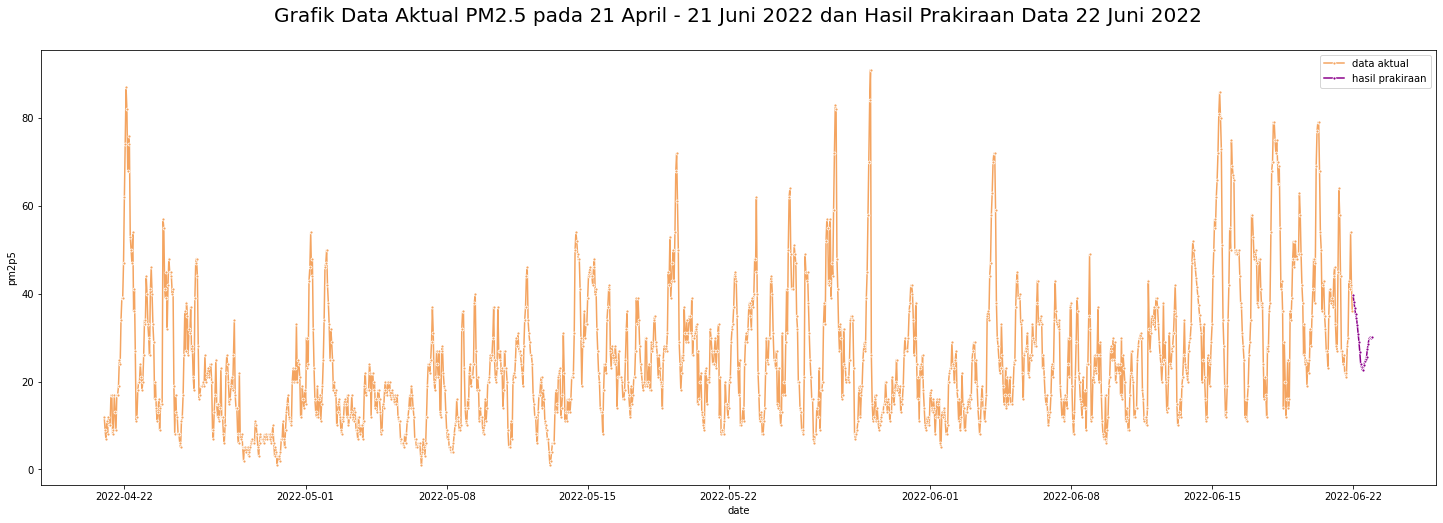

In [141]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="data aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="hasil prakiraan", marker='.', color='darkmagenta')
plt.title("Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n", fontsize = 20)

Text(0.5, 1.0, 'Graph of Actual PM2.5 Data on April 21 - June 21, 2022 and Forecast Result on June 22, 2022\n')

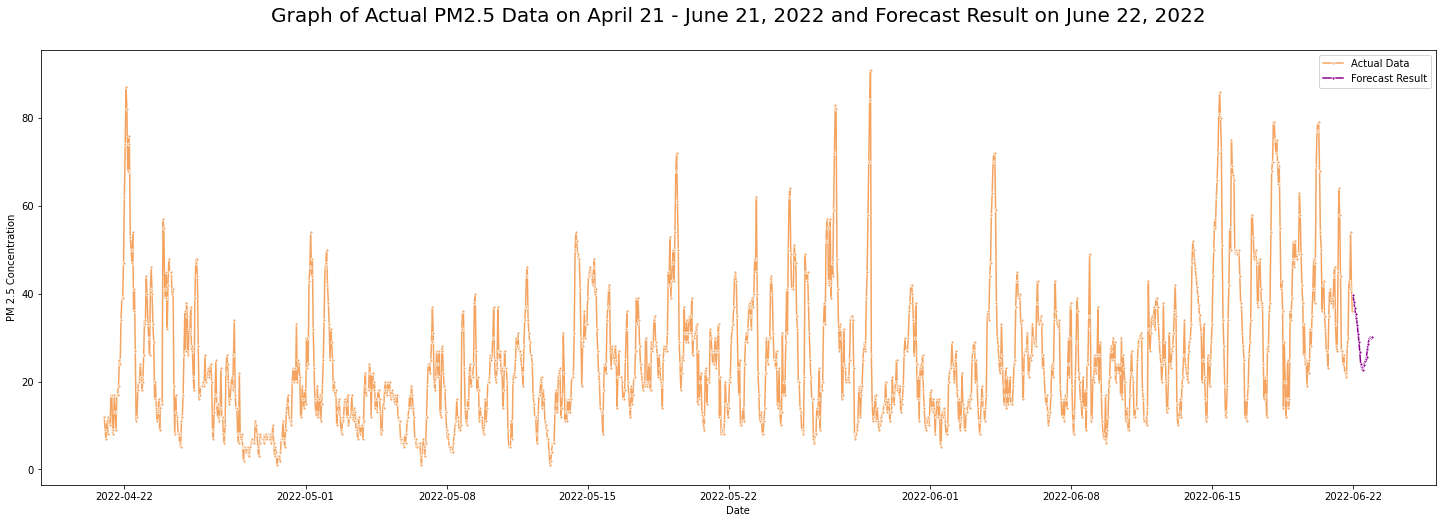

In [142]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="Actual Data", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="Forecast Result", marker='.', color='darkmagenta')
plt.xlabel('Date'); plt.ylabel('PM 2.5 Concentration')
plt.title("Graph of Actual PM2.5 Data on April 21 - June 21, 2022 and Forecast Result on June 22, 2022\n", fontsize = 20)

### with all data method II

In [143]:
# generate the forecasts
y_future = model_forecast(modelBiLSTM, pm2p5_scaled, n_lookback, 1)
print(y_future.shape)

y_future = inverse_normalize_series(y_future, Average(pm2p5), stdev(pm2p5_train.flatten()))
forecast_future_data = y_future[-1]
print(forecast_future_data.shape)
print(forecast_future_data[:5])

1465/1465 [==============================] - 3s 2ms/step
(1465, 24)
(24,)
[39.5952925  38.13828223 36.71020453 35.30818599 34.48104423]


In [144]:
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = dts
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = forecast_future_data
df_forecast

Date   Forecast
0  2022-06-22 00:00:00  39.595293
1  2022-06-22 01:00:00  38.138282
2  2022-06-22 02:00:00  36.710205
3  2022-06-22 03:00:00  35.308186
4  2022-06-22 04:00:00  34.481044
5  2022-06-22 05:00:00  32.849327
6  2022-06-22 06:00:00  30.883007
7  2022-06-22 07:00:00  28.982769
8  2022-06-22 08:00:00  26.641430
9  2022-06-22 09:00:00  24.065074
10 2022-06-22 10:00:00  23.258226
11 2022-06-22 11:00:00  22.794656
12 2022-06-22 12:00:00  22.716329
13 2022-06-22 13:00:00  23.833070
14 2022-06-22 14:00:00  24.605590
15 2022-06-22 15:00:00  25.103928
16 2022-06-22 16:00:00  25.631261
17 2022-06-22 17:00:00  27.443173
18 2022-06-22 18:00:00  28.611530
19 2022-06-22 19:00:00  29.805840
20 2022-06-22 20:00:00  30.127369
21 2022-06-22 21:00:00  29.882952
22 2022-06-22 22:00:00  30.070891
23 2022-06-22 23:00:00  30.155207

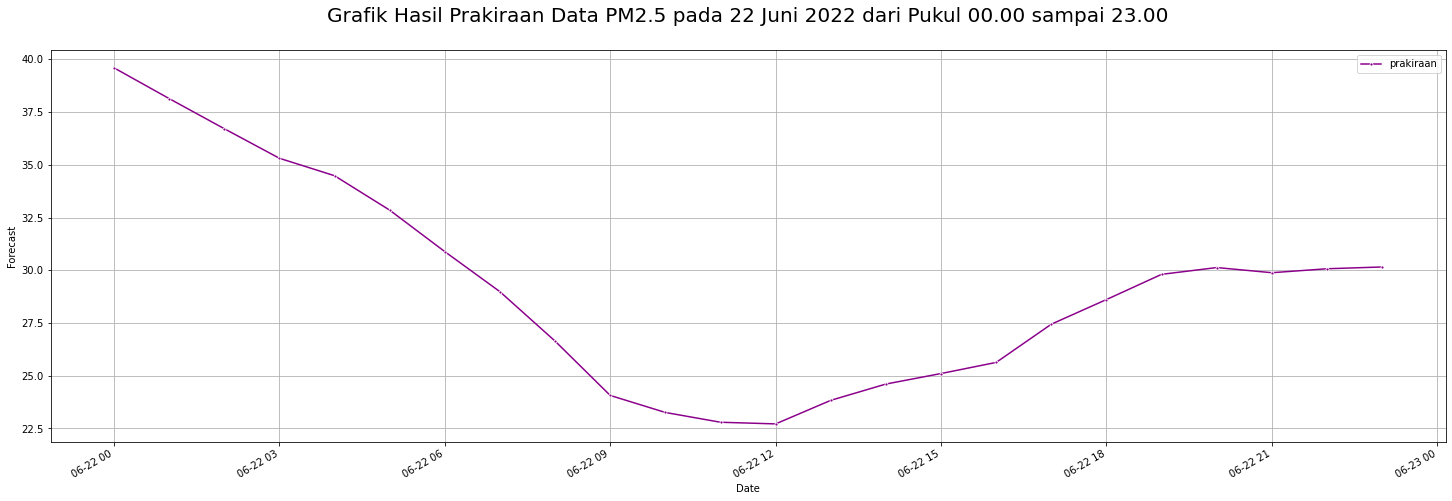

In [145]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="prakiraan", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Grafik Hasil Prakiraan Data PM2.5 pada 22 Juni 2022 dari Pukul 00.00 sampai 23.00\n", fontsize = 20)
plt.grid()

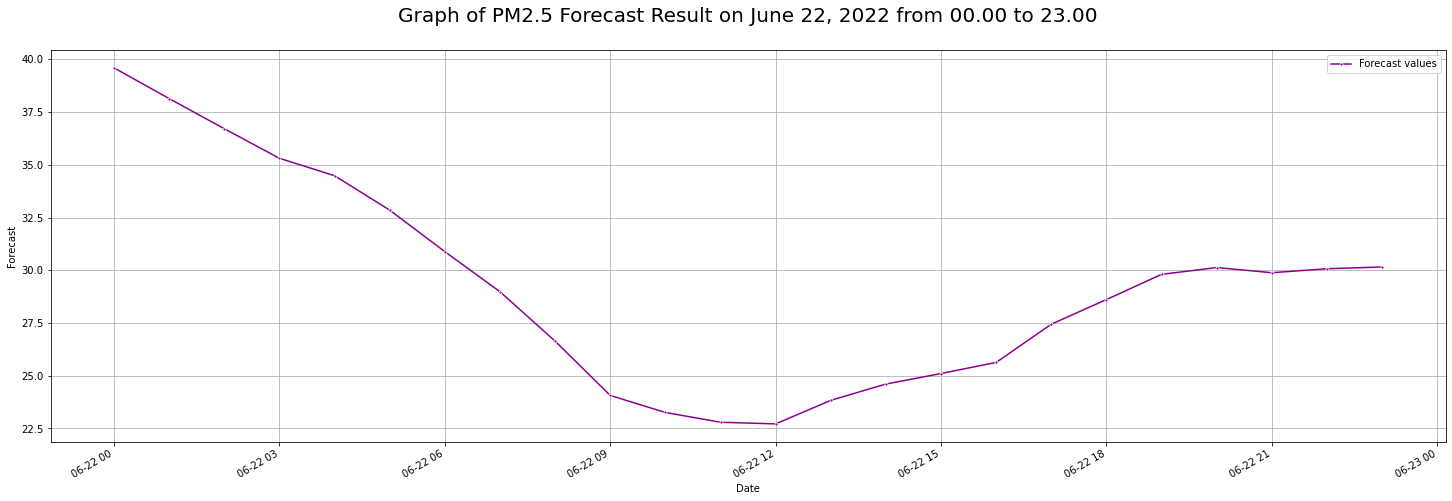

In [146]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="Forecast values", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Graph of PM2.5 Forecast Result on June 22, 2022 from 00.00 to 23.00\n", fontsize = 20)
plt.grid()

Text(0.5, 1.0, 'Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n')

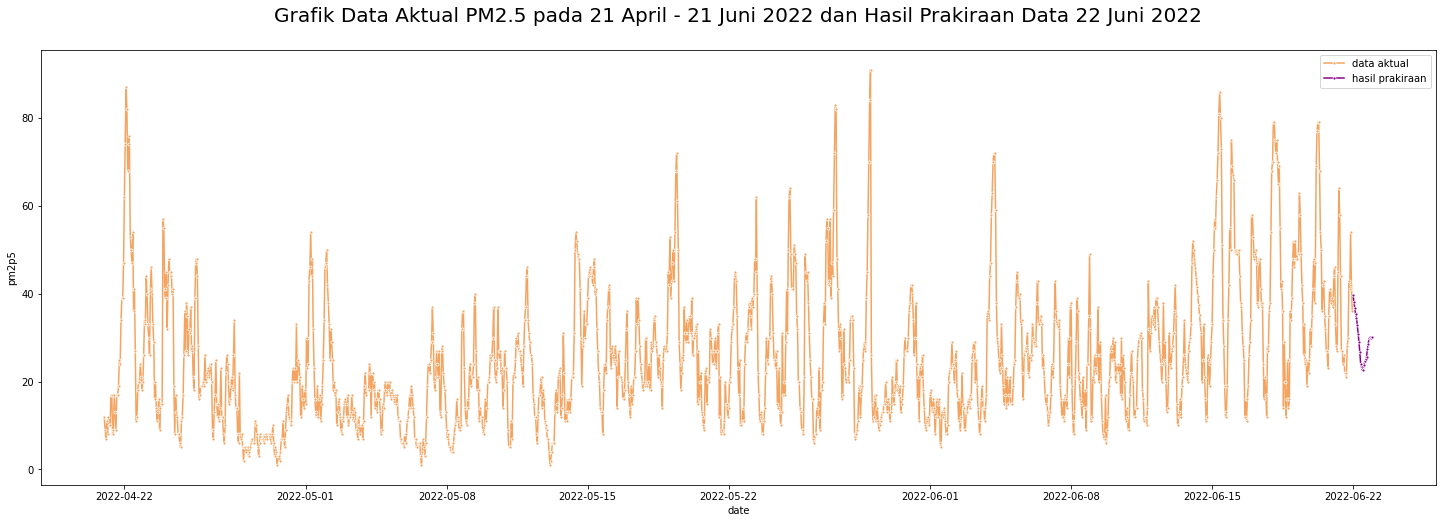

In [147]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="data aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="hasil prakiraan", marker='.', color='darkmagenta')
plt.title("Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n", fontsize = 20)

Text(0.5, 1.0, 'Graph of Actual PM2.5 Data on April 21 - June 21, 2022 and Forecast Result on June 22, 2022\n')

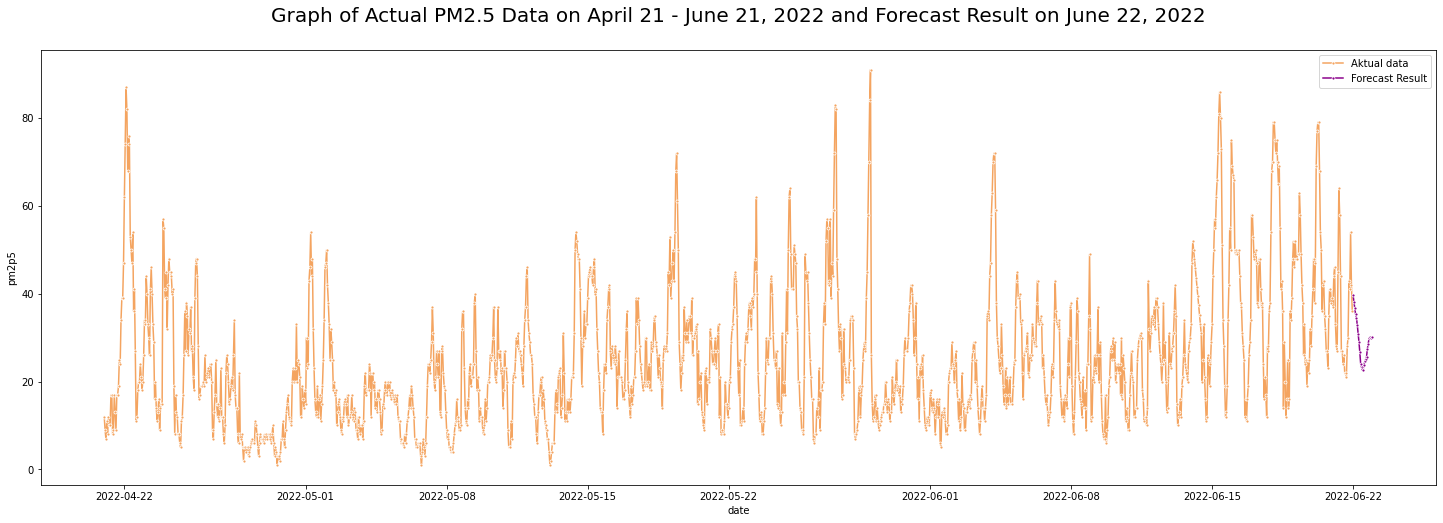

In [148]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="Aktual data", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="Forecast Result", marker='.', color='darkmagenta')
plt.title("Graph of Actual PM2.5 Data on April 21 - June 21, 2022 and Forecast Result on June 22, 2022\n", fontsize = 20)

# 2 Stacked Biderectional LSTM

## Read Model

In [149]:
model2StackedBiLSTM = tf.keras.models.load_model('./Models/UnivariateForecast_2StackedBiLSTM-Model.h5')

In [150]:
y_val_pred = model2StackedBiLSTM.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 3ms/step
(337, 24)


In [151]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = model2StackedBiLSTM.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = model2StackedBiLSTM.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 0s 3ms/step - loss: 0.3191 - mse: 0.7612
train loss, train mse: [0.3191 0.7612]
Evaluate on val data
6/6 [==============================] - 0s 4ms/step - loss: 0.3259 - mse: 0.7721
val loss, val mse: [0.3259 0.7721]


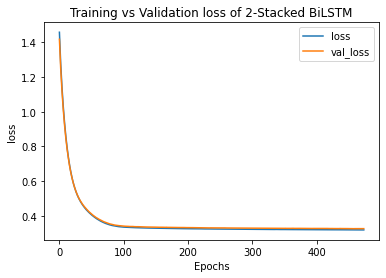

474


In [152]:
with open('./Models/history2StackedBiLSTM', "rb") as file_pi:
    load_history2StackedBiLSTM = pickle.load(file_pi)

plot_graphs(load_history2StackedBiLSTM, "loss", "2-Stacked BiLSTM")
print(len(load_history2StackedBiLSTM['loss']))

## Prediction

### Prediction with training data

In [153]:
forecast_train_data = model_forecast(model2StackedBiLSTM, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 3s 3ms/step
(1009, 24)
(1008,)
1008


In [154]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([37.08800788, 41.8245544 , 47.18354793, 54.59966464, 59.57916446])

In [155]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [156]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  37.088008
1    2022-04-22 01:00:00    74.0  41.824554
2    2022-04-22 02:00:00    87.0  47.183548
3    2022-04-22 03:00:00    82.0  54.599665
4    2022-04-22 04:00:00    68.0  59.579164
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  13.115594
1004 2022-06-02 20:00:00    13.0  13.855462
1005 2022-06-02 21:00:00    15.0  14.569463
1006 2022-06-02 22:00:00    16.0  15.640856
1007 2022-06-02 23:00:00    14.0  16.679079

[1008 rows x 3 columns]

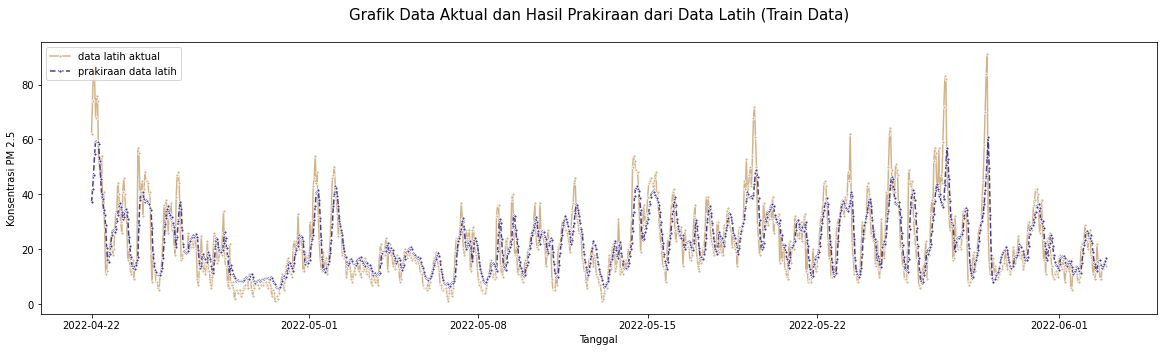

In [157]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [158]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  8.06
MAE:  5.72
MAPE:  0.2695


### Prediction with validation data

In [159]:
forecast_val_data = model_forecast(model2StackedBiLSTM, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 1s 4ms/step
(361, 24)
(360,)
360


In [160]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([39.10136414, 42.60619736, 46.81721497, 50.48919487, 53.48744202])

In [161]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [162]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  39.101364
1   2022-06-04 01:00:00    58.0  42.606197
2   2022-06-04 02:00:00    63.0  46.817215
3   2022-06-04 03:00:00    70.0  50.489195
4   2022-06-04 04:00:00    72.0  53.487442
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  22.859913
356 2022-06-18 20:00:00    16.0  22.589638
357 2022-06-18 21:00:00    36.0  22.695231
358 2022-06-18 22:00:00    34.0  29.699956
359 2022-06-18 23:00:00    39.0  34.591084

[360 rows x 3 columns]

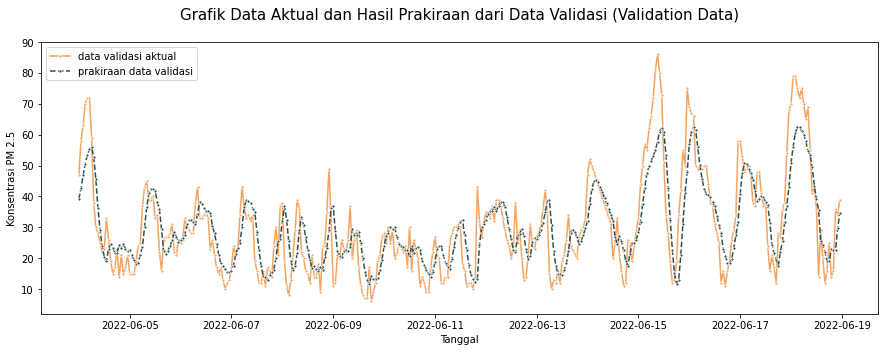

In [163]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [164]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  9.31
MAE:  7.23
MAPE:  0.261


### Prediction with test data

In [165]:
forecast_test_data = model_forecast(model2StackedBiLSTM, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 5ms/step
(49, 24)
(48,)
48


In [166]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([35.02920331, 39.31846954, 45.06141747, 45.04463185, 47.46662225])

In [167]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [168]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  35.029203
1  2022-06-20 01:00:00    48.0  39.318470
2  2022-06-20 02:00:00    38.0  45.061417
3  2022-06-20 03:00:00    47.0  45.044632
4  2022-06-20 04:00:00    69.0  47.466622
5  2022-06-20 05:00:00    77.0  53.338444
6  2022-06-20 06:00:00    79.0  59.589301
7  2022-06-20 07:00:00    79.0  63.561416
8  2022-06-20 08:00:00    68.0  65.288854
9  2022-06-20 09:00:00    54.0  63.659688
10 2022-06-20 10:00:00    50.0  58.452973
11 2022-06-20 11:00:00    36.0  52.844278
12 2022-06-20 12:00:00    42.0  43.572704
13 2022-06-20 13:00:00    43.0  39.267857
14 2022-06-20 14:00:00    35.0  37.834707
15 2022-06-20 15:00:00    32.0  34.741844
16 2022-06-20 16:00:00    27.0  31.897096
17 2022-06-20 17:00:00    27.0  28.847958
18 2022-06-20 18:00:00    23.0  27.491150
19 2022-06-20 19:00:00    35.0  26.538256
20 2022-06-20 20:00:00    41.0  30.414169
21 2022-06-20 21:00:00    41.0  36.458473
22 2022-06-20 22:00:00    38.0  41.283281
23 2022-06-20 23:00:00    39.0  43.247250
24 2022-06-21 00:00:00    37.0  44.187756
25 2022-06-21 01:00:00    44.0  43.680939
26 2022-06-21 02:00:00    46.0  45.525102
27 2022-06-21 03:00:00    33.0  46.983650
28 2022-06-21 04:00:00    28.0  42.257108
29 2022-06-21 05:00:00    27.0  36.328159
30 2022-06-21 06:00:00    45.0  31.731049
31 2022-06-21 07:00:00    64.0  35.653930
32 2022-06-21 08:00:00    58.0  44.251893
33 2022-06-21 09:00:00    44.0  50.270432
34 2022-06-21 10:00:00    27.0  50.159708
35 2022-06-21 11:00:00    27.0  42.197899
36 2022-06-21 12:00:00    24.0  35.111882
37 2022-06-21 13:00:00    26.0  29.779320
38 2022-06-21 14:00:00    22.0  27.353297
39 2022-06-21 15:00:00    22.0  25.383392
40 2022-06-21 16:00:00    21.0  24.381949
41 2022-06-21 17:00:00    28.0  23.875661
42 2022-06-21 18:00:00    30.0  25.776705
43 2022-06-21 19:00:00    43.0  28.428285
44 2022-06-21 20:00:00    41.0  35.472049
45 2022-06-21 21:00:00    54.0  40.332791
46 2022-06-21 22:00:00    42.0  47.196194
47 2022-06-21 23:00:00    36.0  48.124200

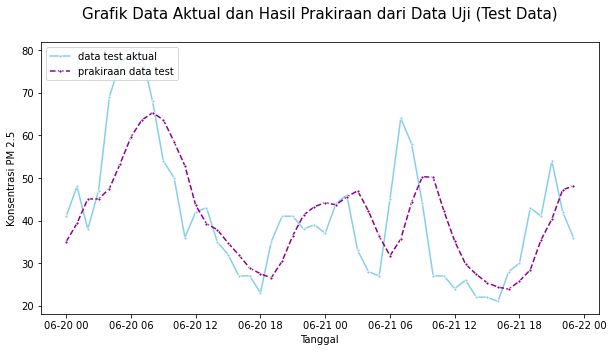

In [169]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [170]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  11.1
MAE:  8.89
MAPE:  0.2189


## Summary Eval Metric

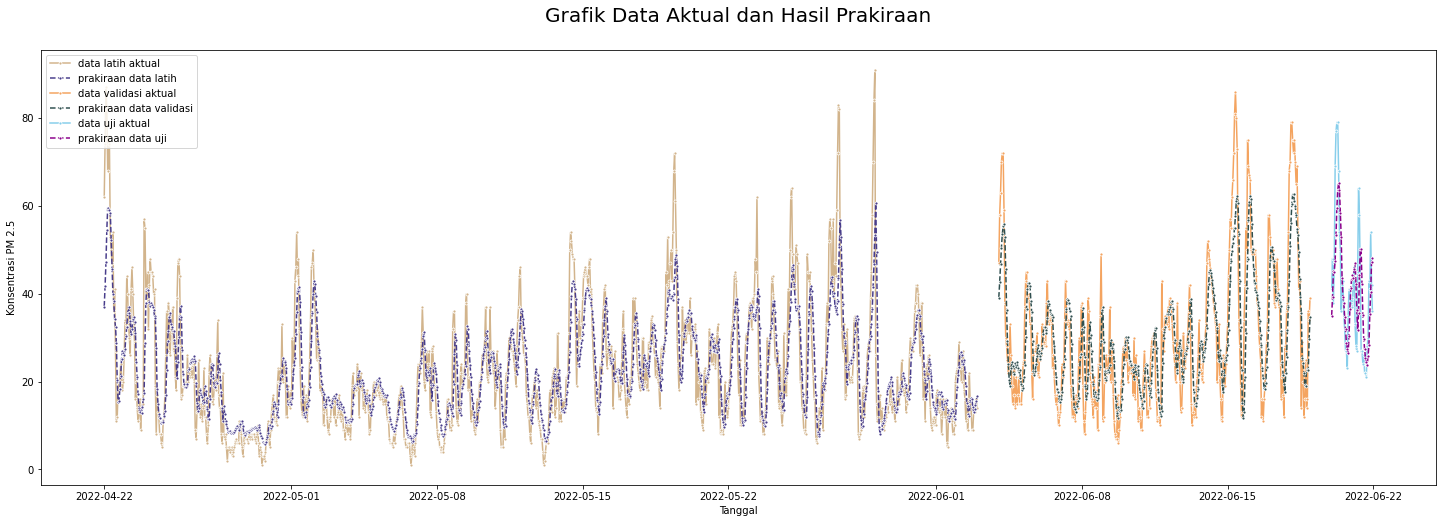

In [171]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [172]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  8.06
MAE:  5.72
MAPE:  0.2695
Forecast Val accuracy
RMSE:  9.31
MAE:  7.23
MAPE:  0.261
Forecast Test accuracy
RMSE:  11.1
MAE:  8.89
MAPE:  0.2189


# 3 Stacked Biderectional LSTM

## Read Model

In [173]:
model3StackedBiLSTM = tf.keras.models.load_model('./Models/UnivariateForecast_3StackedBiLSTM-Model.h5')

In [174]:
y_val_pred = model3StackedBiLSTM.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 1s 6ms/step
(337, 24)


In [175]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = model3StackedBiLSTM.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = model3StackedBiLSTM.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 1s 7ms/step - loss: 0.3358 - mse: 0.7904
train loss, train mse: [0.3358 0.7904]
Evaluate on val data
6/6 [==============================] - 0s 7ms/step - loss: 0.3331 - mse: 0.7722
val loss, val mse: [0.3331 0.7722]


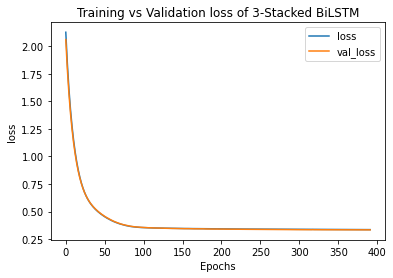

392


In [176]:
with open('./Models/history3StackedBiLSTM', "rb") as file_pi:
    load_history3StackedBiLSTM = pickle.load(file_pi)

plot_graphs(load_history3StackedBiLSTM, "loss", "3-Stacked BiLSTM")
print(len(load_history3StackedBiLSTM['loss']))

## Prediction

### Prediction with training data

In [177]:
forecast_train_data = model_forecast(model3StackedBiLSTM, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 5s 4ms/step
(1009, 24)
(1008,)
1008


In [178]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([34.10351558, 37.69252677, 40.92226215, 41.823801  , 41.57168193])

In [179]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [180]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  34.103516
1    2022-04-22 01:00:00    74.0  37.692527
2    2022-04-22 02:00:00    87.0  40.922262
3    2022-04-22 03:00:00    82.0  41.823801
4    2022-04-22 04:00:00    68.0  41.571682
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  15.148592
1004 2022-06-02 20:00:00    13.0  15.527071
1005 2022-06-02 21:00:00    15.0  15.925765
1006 2022-06-02 22:00:00    16.0  16.570997
1007 2022-06-02 23:00:00    14.0  17.222084

[1008 rows x 3 columns]

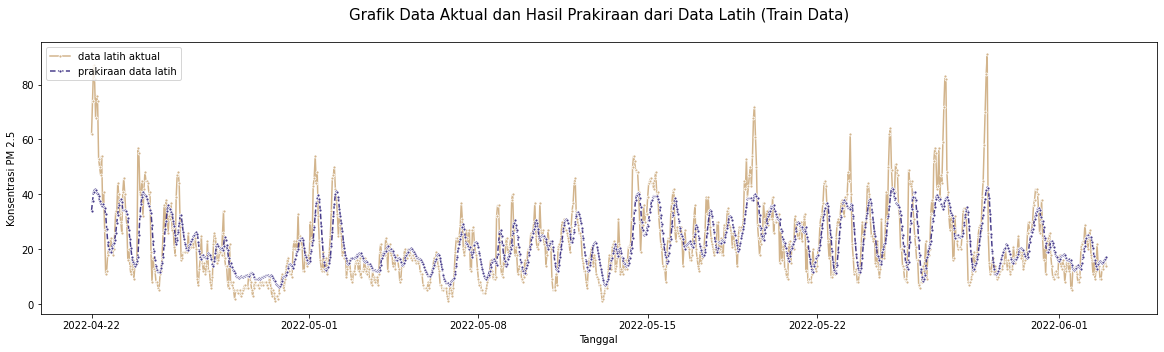

In [181]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [182]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  9.13
MAE:  6.56
MAPE:  0.2992


### Prediction with validation data

In [183]:
forecast_val_data = model_forecast(model3StackedBiLSTM, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 2s 4ms/step
(361, 24)
(360,)
360


In [184]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([36.27946758, 39.97198868, 43.53765011, 46.37290382, 48.84006882])

In [185]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [186]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  36.279468
1   2022-06-04 01:00:00    58.0  39.971989
2   2022-06-04 02:00:00    63.0  43.537650
3   2022-06-04 03:00:00    70.0  46.372904
4   2022-06-04 04:00:00    72.0  48.840069
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  21.522002
356 2022-06-18 20:00:00    16.0  21.259963
357 2022-06-18 21:00:00    36.0  21.747717
358 2022-06-18 22:00:00    34.0  26.903125
359 2022-06-18 23:00:00    39.0  31.412823

[360 rows x 3 columns]

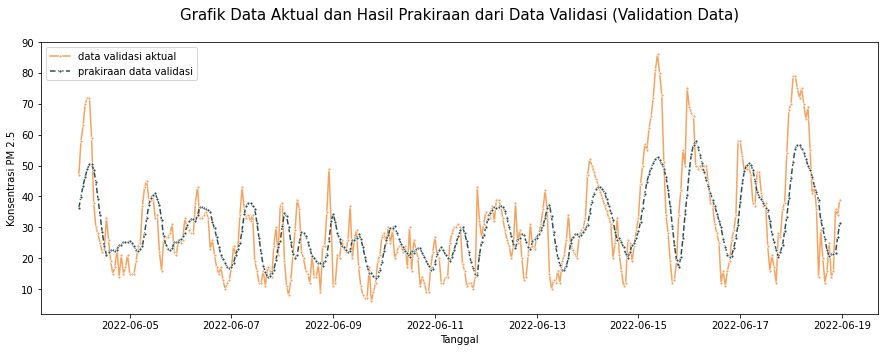

In [187]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [188]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  10.62
MAE:  8.16
MAPE:  0.2821


### Prediction with test data

In [189]:
forecast_test_data = model_forecast(model3StackedBiLSTM, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 4ms/step
(49, 24)
(48,)
48


In [190]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([34.88913907, 38.61782302, 43.36270226, 44.72130145, 47.19138516])

In [191]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [192]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  34.889139
1  2022-06-20 01:00:00    48.0  38.617823
2  2022-06-20 02:00:00    38.0  43.362702
3  2022-06-20 03:00:00    47.0  44.721301
4  2022-06-20 04:00:00    69.0  47.191385
5  2022-06-20 05:00:00    77.0  51.673582
6  2022-06-20 06:00:00    79.0  55.898594
7  2022-06-20 07:00:00    79.0  59.081582
8  2022-06-20 08:00:00    68.0  60.263812
9  2022-06-20 09:00:00    54.0  59.397235
10 2022-06-20 10:00:00    50.0  56.988723
11 2022-06-20 11:00:00    36.0  53.854688
12 2022-06-20 12:00:00    42.0  47.772422
13 2022-06-20 13:00:00    43.0  43.580435
14 2022-06-20 14:00:00    35.0  40.650709
15 2022-06-20 15:00:00    32.0  36.853181
16 2022-06-20 16:00:00    27.0  33.716092
17 2022-06-20 17:00:00    27.0  30.923798
18 2022-06-20 18:00:00    23.0  29.250822
19 2022-06-20 19:00:00    35.0  27.903921
20 2022-06-20 20:00:00    41.0  29.710613
21 2022-06-20 21:00:00    41.0  33.608538
22 2022-06-20 22:00:00    38.0  37.549546
23 2022-06-20 23:00:00    39.0  40.341272
24 2022-06-21 00:00:00    37.0  42.677514
25 2022-06-21 01:00:00    44.0  43.747137
26 2022-06-21 02:00:00    46.0  45.821574
27 2022-06-21 03:00:00    33.0  47.668410
28 2022-06-21 04:00:00    28.0  45.683173
29 2022-06-21 05:00:00    27.0  42.278817
30 2022-06-21 06:00:00    45.0  38.542510
31 2022-06-21 07:00:00    64.0  39.066998
32 2022-06-21 08:00:00    58.0  42.961448
33 2022-06-21 09:00:00    44.0  46.225904
34 2022-06-21 10:00:00    27.0  46.728729
35 2022-06-21 11:00:00    27.0  43.369168
36 2022-06-21 12:00:00    24.0  39.641566
37 2022-06-21 13:00:00    26.0  35.464180
38 2022-06-21 14:00:00    22.0  32.233720
39 2022-06-21 15:00:00    22.0  29.289574
40 2022-06-21 16:00:00    21.0  27.260802
41 2022-06-21 17:00:00    28.0  25.903491
42 2022-06-21 18:00:00    30.0  26.598004
43 2022-06-21 19:00:00    43.0  28.172412
44 2022-06-21 20:00:00    41.0  32.803414
45 2022-06-21 21:00:00    54.0  36.736338
46 2022-06-21 22:00:00    42.0  42.886443
47 2022-06-21 23:00:00    36.0  45.511756

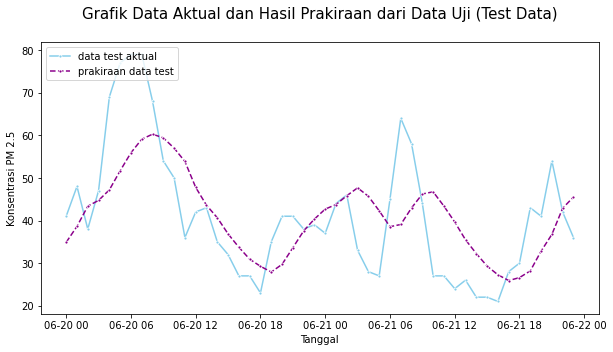

In [193]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [194]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  11.78
MAE:  9.5
MAPE:  0.2324


## Summary Eval Metric

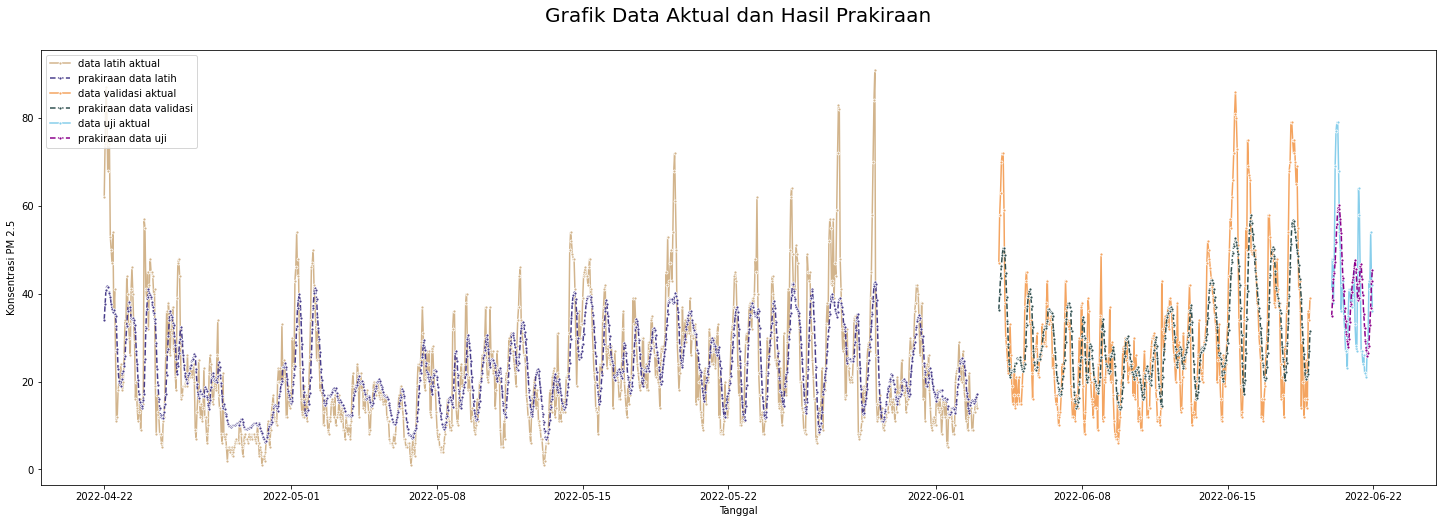

In [195]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [196]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  9.13
MAE:  6.56
MAPE:  0.2992
Forecast Val accuracy
RMSE:  10.62
MAE:  8.16
MAPE:  0.2821
Forecast Test accuracy
RMSE:  11.78
MAE:  9.5
MAPE:  0.2324


# History Graph

In [197]:
def plot_graphs(history, metric):
    plt.plot(history[metric])
    plt.plot(history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla LSTM")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

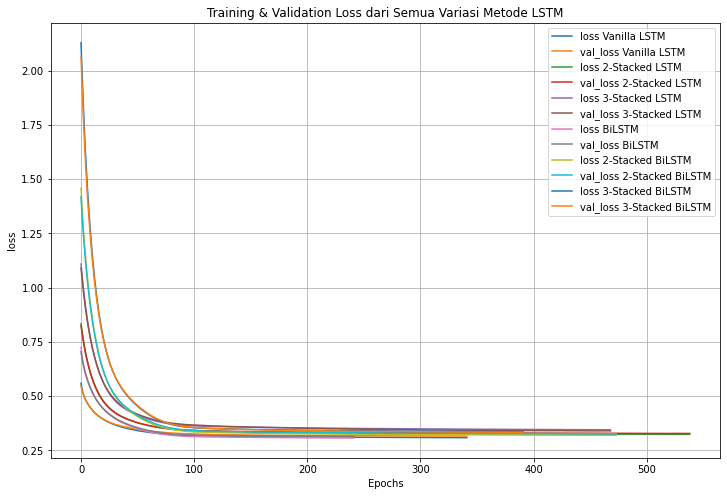

In [198]:
plt.subplots(figsize=(12, 8))
plt.plot(load_historyVanillaLSTM["loss"])
plt.plot(load_historyVanillaLSTM['val_loss'])
plt.plot(load_history2StackedLSTM["loss"])
plt.plot(load_history2StackedLSTM['val_loss'])
plt.plot(load_history3StackedLSTM["loss"])
plt.plot(load_history3StackedLSTM['val_loss'])


plt.plot(load_historyBiLSTM["loss"])
plt.plot(load_historyBiLSTM['val_loss'])
plt.plot(load_history2StackedBiLSTM["loss"])
plt.plot(load_history2StackedBiLSTM['val_loss'])
plt.plot(load_history3StackedBiLSTM["loss"])
plt.plot(load_history3StackedBiLSTM['val_loss'])

plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title(f"Training & Validation Loss dari Semua Variasi Metode LSTM")
plt.legend(["loss Vanilla LSTM", 'val_loss Vanilla LSTM',
            "loss 2-Stacked LSTM", 'val_loss 2-Stacked LSTM',
            "loss 3-Stacked LSTM", 'val_loss 3-Stacked LSTM',  
            "loss BiLSTM", 'val_loss BiLSTM',
            "loss 2-Stacked BiLSTM", 'val_loss 2-Stacked BiLSTM',
            "loss 3-Stacked BiLSTM", 'val_loss 3-Stacked BiLSTM', ])
plt.grid()